In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import scanpy as sc
import anndata as ad
import h5py  
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from utils import MMD, LISI, random_forest, norm_total
import pandas as pd
from pathlib import Path
from torch.distributions import Normal
from scvi.distributions import NegativeBinomial
import scvelo as scv
from torch.distributions import Poisson, Bernoulli
import muon as mu
import yaml
from statannotations.Annotator import Annotator
import seaborn as sns  
from tqdm import tqdm

import sys
sys.path.append('../../Autoencoder')
from autoencoder.data.scrnaseq_loader import RNAseqLoader
from autoencoder.models.base.encoder_model import EncoderModel

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/lightning_lite/__init__.py:29: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_lite')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/pytorch_lightning/__init__.py:45: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420

In [48]:
encoder_config = "encoder_multimodal"
dataset_path = '/stor/lep/diffusion/multiome/openproblem_filtered.h5mu'
# '/stor/lep/diffusion/multiome/openproblems_2500gene_03atac_4w.h5mu'
# '/stor/lep/data/pbmc10k_multiome/cfgen/pbmc10k_multiome_all_2500gene_006atac.h5mu'
  #"/stor/lep/data/BABEL/all.h5mu"
covariate_keys = "cell_type" #"leiden"
num_class = 22 #14 #22 #33
# ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_babel_multimodal/checkpoints/epoch_39.ckpt"
ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal/checkpoints/last.ckpt"
# ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_layernorm/checkpoints/last.ckpt"
# ae_path = "/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_pbmc10k_cfgen_small/checkpoints/last.ckpt"

# load data

In [49]:
# mdata = mu.read_h5mu('/stor/lep/data/pbmc10k_multiome/pbmc10k.h5mu')
# mdata = mu.read_h5mu('/stor/lep/diffusion/multiome/openproblem_filtered.h5mu')
mdata = mu.read_h5mu(dataset_path)
gene_names = mdata['rna'].var_names
real_cell = mdata['rna'][::10].X.toarray()#.layers['X_counts'].toarray()
real_cell2 = mdata['atac'][::10].X.toarray()
# real_cell = mdata['rna'][mdata['rna'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
# real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']=='CD4+ T activated'].X.toarray()[::7]
real_cell.shape

(6925, 13431)

In [347]:
np.unique(mdata['rna'].obs['cell_type'].values,return_counts=True)

(array(['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC'], dtype=object),
 array([ 1890, 10843,  1894,  5526,  4398, 11589,  1012,  4916,  1203,
         1072,   108,   835,  1779,   884,  6929,  5052,  1780,   379,
         2300,  2810,   859,  1191]))

In [363]:
# file_path = '/stor/lep/diffusion/hECA/rowcount/hECA_all_rowcount.h5ad'
# file_path = '/data1/lep/Workspace/guided-diffusion/data/tabula_muris/all.h5ad'
file_path = '/stor/lep/diffusion/multiome/openproblems_ATAC_new.h5ad'
h5_file= h5py.File(file_path, 'r')

In [4]:
real_cell = []
num_cols = h5_file['X'].attrs['shape'][1]  
gene_names = h5_file['var']['_index'][:].astype(str)
# for i in range(0,8000000,1000):
# for i in range(0,8000):
for i in range(0,69000,10):
    start_id = h5_file['X']['indptr'][i]
    end_id = h5_file['X']['indptr'][i+1]

    row_data = h5_file['X/data'][start_id:end_id]  
    row_indices = h5_file['X/indices'][start_id:end_id]  
        
    X_row_array = np.zeros(num_cols)  
    X_row_array[row_indices] = row_data

    if X_row_array.sum() < 1:
        continue
    # X_row_array = norm_total(X_row_array)
    # X_row_array = np.log1p(X_row_array)
    real_cell.append(X_row_array)

real_cell_ori = torch.tensor(np.stack(real_cell,axis=0),dtype=torch.float32)
real_cell = real_cell_ori.detach().numpy()
real_cell.shape

NameError: name 'h5_file' is not defined

generate with naive AE

In [19]:
# read generated latent representation and decode back to gene expression/atac seq
rna_seq = np.load('/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/samples/w256_scale123_drop0_addlinear_80w_cfgen_rescale_nocross/dpm_solver_20w/RNA_0.npz')['data']
# pretrained_model_path = '/stor/lep/workspace/multi_diffusion/VAE/final_cvqvae_open_ATAC_lr1e4_15w_mse20_l2_closest_lib256/checkpoint-140000/vqmodel'
# model = VQModel.from_pretrained(pretrained_model_path,cvq_distance = 'l2',cvq_anchor='closest')

pretrained_model_path = '/stor/lep/workspace/multi_diffusion/VAE/recons_final_cvqvae_open_RNA_lr1e4_15w_cos_randompro_norelu/checkpoint-150000/vqmodel'
model = VQModel.from_pretrained(pretrained_model_path,cvq_distance = 'cos',cvq_anchor='probrandom')
# rna 0.8587, atac 0.6280
cells = model.decode(torch.tensor(rna_seq*0.8587), return_dict=False)[0]
cells = model.relu(cells)
# cells = F.sigmoid(cells)
reconstruct = cells[:real_cell_ori.shape[0]].detach().numpy()
real_cell = real_cell_ori.detach().numpy()
reconstruct.shape

RuntimeError: shape '[-1, 512]' is invalid for input of size 700000

# generate with CFGen

In [50]:
dataset = RNAseqLoader(data_path=dataset_path,
                            layer_key='X_counts',
                            covariate_keys=[covariate_keys],
                            subsample_frac=1, 
                            encoder_type='learnt_autoencoder',
                            multimodal=True,
                            is_binarized=True)

size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                            "sd": dataset.log_size_factor_sd}

def get_size_factor(type_index):
    covariate_indices = {}
    # covariate_indices['cell_type'] = torch.randint(0, 22, (batch_size,))
    covariate_indices[covariate_keys] = type_index#(torch.ones(batch_size)*3).to(torch.int)


    mean_size_factor, sd_size_factor = size_factor_statistics["mean"][covariate_keys], size_factor_statistics["sd"][covariate_keys]
    mean_size_factor, sd_size_factor = mean_size_factor[covariate_indices[covariate_keys]], sd_size_factor[covariate_indices[covariate_keys]]
    size_factor_dist = Normal(loc=mean_size_factor, scale=sd_size_factor)
    log_size_factor = size_factor_dist.sample().view(-1, 1)
    size_factor = torch.exp(log_size_factor)
    # size_factor = torch.exp(mean_size_factor.view(-1, 1))
    return {"rna": size_factor}

In [121]:
dataset.id2cov

{'cell_type': {'B1 B': 0,
  'CD14+ Mono': 1,
  'CD16+ Mono': 2,
  'CD4+ T activated': 3,
  'CD4+ T naive': 4,
  'CD8+ T': 5,
  'CD8+ T naive': 6,
  'Erythroblast': 7,
  'G/M prog': 8,
  'HSC': 9,
  'ID2-hi myeloid prog': 10,
  'ILC': 11,
  'Lymph prog': 12,
  'MK/E prog': 13,
  'NK': 14,
  'Naive CD20+ B': 15,
  'Normoblast': 16,
  'Plasma cell': 17,
  'Proerythroblast': 18,
  'Transitional B': 19,
  'cDC2': 20,
  'pDC': 21}}

sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x765ebed749a0>


In [51]:
with open(f'{os.getcwd()}/../../CFGen/configs/configs_encoder/encoder/{encoder_config}.yaml', 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)

# Initialize encoder                'atac': 143810, 'rna': 19448
# autoencoder_args['encoder_kwargs']['rna']['norm_type']='layernorm'
# autoencoder_args['encoder_kwargs']['atac']['norm_type']='layernorm'
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=mdata['rna'].obs[covariate_keys].unique().shape[0],
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])
# encoder_model.load_state_dict(torch.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_pbmc10k/checkpoints/last.ckpt')["state_dict"])
# encoder_model.eval()

<All keys matched successfully>

In [293]:
import pickle
from sklearn.preprocessing import StandardScaler

# 从文件加载 scaler
with open('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_fixed/scaler_rna.pkl', 'rb') as file:
    scaler_rna = pickle.load(file)
with open('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/train_autoencoder_openproblem_multimodal_fixed/scaler_atac.pkl', 'rb') as file:
    scaler_atac = pickle.load(file)

In [68]:
# read generated latent representation and decode back to gene expression/atac seq
rna_seq = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['data']
atac_seq = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/ATAC_0.npz')['data']
type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label']

# rna_seq = np.load('../outputs/samples_new/open_lr1e4_w512_scale124_80w_condi_wd1e4_nocross/80w_all_condi/RNA_0.npz')['data']
# atac_seq = np.load('../outputs/samples_new/open_lr1e4_w512_scale124_80w_condi_wd1e4_nocross/80w_all_condi/ATAC_0.npz')['data']
# type_index = np.load('../outputs/samples_new/open_lr1e4_w512_scale124_80w_condi_wd1e4_nocross/80w_all_condi/RNA_0.npz')['label']
rna_seq_aug = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/cDC2/RNA_0.npz')['data'][:1500]
atac_seq_aug = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/cDC2/ATAC_0.npz')['data'][:1500]
type_index_aug = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/cDC2/RNA_0.npz')['label'][:1500]
rna_seq = np.concatenate([rna_seq,rna_seq_aug])
atac_seq = np.concatenate([atac_seq,atac_seq_aug])
type_index = np.concatenate([type_index,type_index_aug])

# rna_seq = np.load('../outputs/samples_new/pbmc10k_w384_scale124_80w_condi_2500_006_small_wd1e4_8k/60w_all_condi/RNA_0.npz')['data']
# atac_seq = np.load('../outputs/samples_new/pbmc10k_w384_scale124_80w_condi_2500_006_small_wd1e4_8k/60w_all_condi/ATAC_0.npz')['data']
# type_index = np.load('../outputs/samples_new/pbmc10k_w384_scale124_80w_condi_2500_006_small_wd1e4_8k/60w_all_condi/RNA_0.npz')['label']

npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
# z = {'rna':torch.tensor(rna_seq*16.151).squeeze(1),'atac':torch.tensor(atac_seq*37.948).squeeze(1)}     # open
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}     # open  layernorm
# z = {'rna':torch.tensor(rna_seq*15.726).squeeze(1),'atac':torch.tensor(atac_seq*31.398).squeeze(1)}

size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))
mu_hat = encoder_model.decode(z, size_factor)


sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        # if not self.covariate_specific_theta:
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
        # else:
        #     distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta[covariate_indices[theta_covariate]]))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct = sample['rna'][:real_cell.shape[0]].detach().numpy()
reconstruct2 = sample['atac'][:real_cell.shape[0]].detach().numpy()
# reconstruct = sample['rna'][type_index==3][:real_cell.shape[0]].detach().numpy()
# reconstruct2 = sample['atac'][type_index==3][:real_cell.shape[0]].detach().numpy()
# reconstruct = sample['rna'][type_index==3][:600].detach().numpy()
# reconstruct2 = sample['atac'][type_index==3][:600].detach().numpy()

reconstruct.shape

(6925, 13431)

# evaluation

In [46]:
print('RNA')
print(real_cell.mean())
print(reconstruct.mean())
print('spearman=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])
print('MSE=',np.mean((reconstruct-real_cell)**2))
print('L2 Norm=',np.linalg.norm(reconstruct.mean(axis=0)-real_cell.mean(axis=0)))

print('\nATAC')
print(real_cell2.mean())
print(reconstruct2.mean())
print('spearman=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])
print('MSE=',np.mean((reconstruct2-real_cell2)**2))
print('L2 Norm=',np.linalg.norm(reconstruct2.mean(axis=0)-real_cell2.mean(axis=0)))

RNA
0.14379396
0.1444168
spearman= 0.9926489636327742
pearson= 0.9857817810530323
MSE= 6.720524
L2 Norm= 14.3146715

ATAC
0.07920893
0.078574635
spearman= 0.983651534948117
pearson= 0.9976532396450162
MSE= 0.13375072
L2 Norm= 1.0046645


In [47]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

RNA


100%|██████████| 70/70 [00:18<00:00,  3.73it/s]


MMD =  tensor(0.0031)
LISI =  0.8461635290593872
AUC =  0.6527138107423703

ATAC


100%|██████████| 70/70 [00:17<00:00,  3.90it/s]


MMD =  tensor(0.0010)
LISI =  0.9230115952139442
AUC =  0.5706207189153563


RNA

ATAC


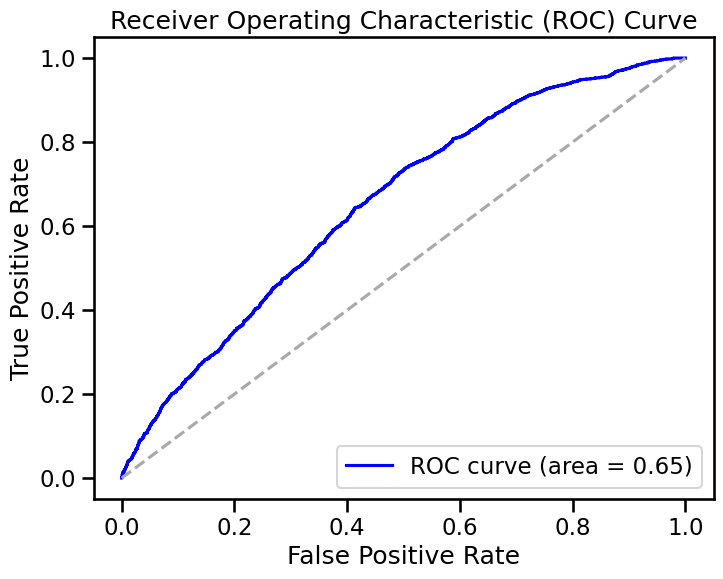

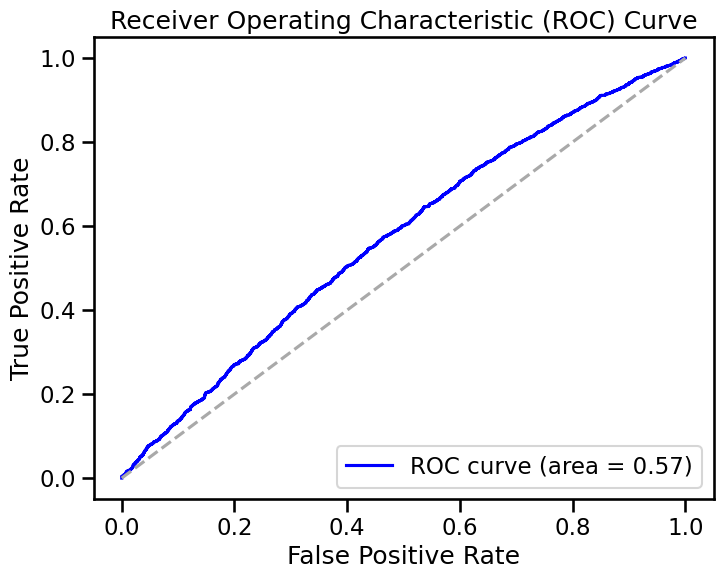

In [330]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
aucval, fpr_Nb, tpr_Nb = random_forest(adata,True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 6))
plt.plot(fpr_Nb, tpr_Nb, color='blue', label='ROC curve (area = %0.2f)' % aucval)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/AUC_curve/diffusion_rna.pdf')


print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
aucval, fpr_Nb, tpr_Nb = random_forest(adata,True)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 6))
plt.plot(fpr_Nb, tpr_Nb, color='blue', label='ROC curve (area = %0.2f)' % aucval)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/AUC_curve/diffusion_atac.pdf')

random forest

In [55]:
type_list = np.unique(mdata['rna'].obs['cell_type'].values,return_counts=True)
type_list

(array(['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC'], dtype=object),
 array([ 1890, 10843,  1894,  5526,  4398, 11589,  1012,  4916,  1203,
         1072,   108,   835,  1779,   884,  6929,  5052,  1780,   379,
         2300,  2810,   859,  1191]))

<AxesSubplot:title={'center':'umap of unconditional generation RNA'}, xlabel='UMAP1', ylabel='UMAP2'>

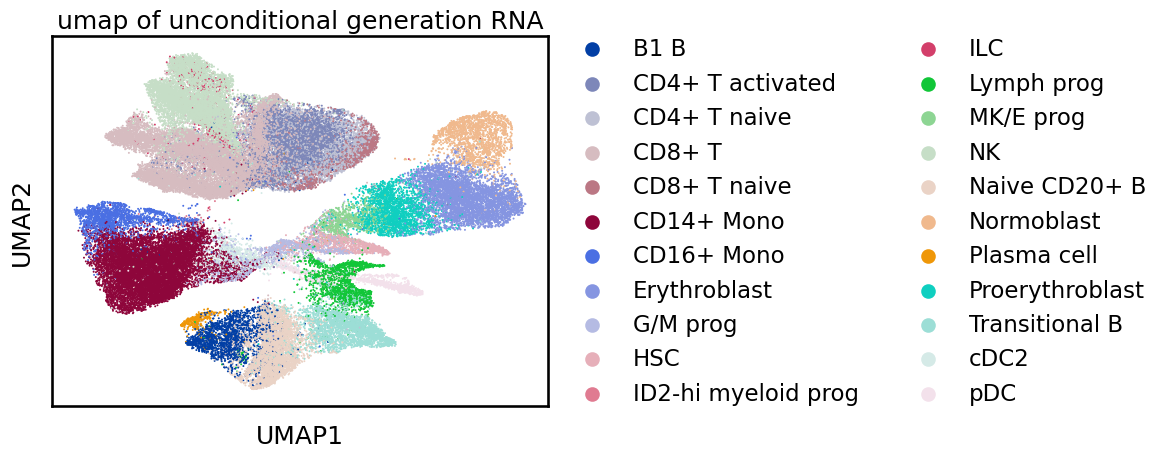

In [21]:
adata = mdata['rna']
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_type', size=8, title='umap of RNA', show=False)

<AxesSubplot:title={'center':'umap of RNA'}, xlabel='UMAP1', ylabel='UMAP2'>

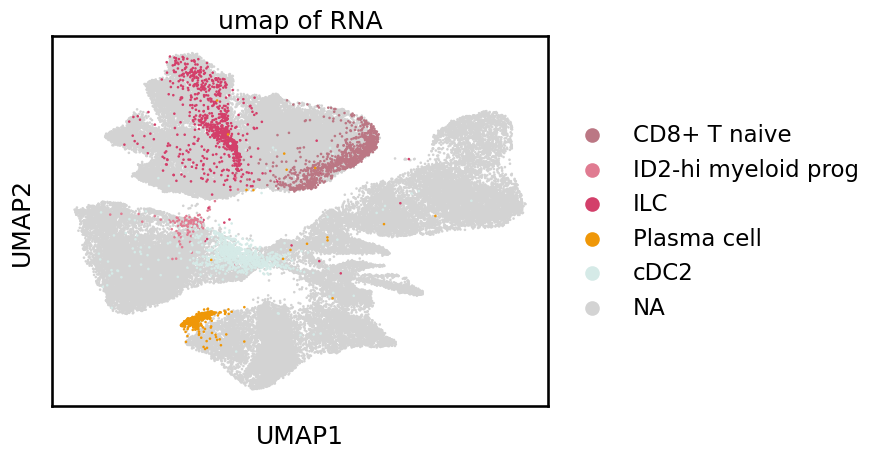

In [65]:
sc.pl.umap(adata, color='cell_type', groups=['ILC','cDC2','Plasma cell','ID2-hi myeloid prog','CD8+ T naive'], size=14, title='umap of RNA', show=False)

In [70]:
# 多分类

from sklearn.model_selection import  train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

mdata = mu.read_h5mu(dataset_path)

for aug_num in [363,726,1089,1452,1815]:
# for iii in range(2):

    adata_real_rna = mdata['rna']
    adata_real_atac = mdata['atac']
    # generated
    aug_idx = np.where(np.in1d(type_index,[20,])==1)[0][:aug_num] #list(range(type_index.shape[0]))
    adata_gen_rna = ad.AnnData(sample['rna'][aug_idx].detach().numpy(),var=adata_real_rna.var)
    adata_gen_atac = ad.AnnData(sample['atac'][aug_idx].detach().numpy(),var=adata_real_atac.var)
    adata_real_rna = ad.concat([adata_real_rna,adata_gen_rna])
    adata_real_atac = ad.concat([adata_real_atac,adata_gen_atac])

    sc.tl.pca(adata_real_rna, svd_solver='arpack')
    sc.tl.pca(adata_real_atac, svd_solver='arpack')

    rna_pca = adata_real_rna.obsm['X_pca']
    atac_pca = adata_real_atac.obsm['X_pca']
    data = np.concatenate([rna_pca,atac_pca],axis=-1)
    label = list(mdata['rna'].obs['cell_type'].values)# + list(type_list[0][type_index[aug_idx]])

    ##将训练集切分为训练集和验证集
    X_train,X_val,y_train,y_val = train_test_split(data[:mdata['rna'].shape[0]], label,
                                                test_size = 0.25,random_state = 1)
    # generated
    X_train = np.concatenate([X_train,data[mdata['rna'].shape[0]:]])
    y_train = np.concatenate([y_train,type_list[0][type_index[aug_idx]]])

    # # duplicated
    # index_dup = np.where(np.array(y_train)=='cDC2')[0]
    # X_train = np.concatenate([X_train]+[X_train[index_dup]]+[X_train[index_dup][:363]])
    # y_train = np.concatenate([y_train]+[np.array(y_train)[index_dup]]+[np.array(y_train)[index_dup][:363]])

    ## 使用随机森林对数据进行分类
    model = RandomForestClassifier(n_estimators = 100, # 树的数量
                                max_depth= 5,       # 子树最大深度
                                oob_score=True,
                                random_state=1)
    model.fit(X_train,y_train)

    # 7. 模型评估
    y_pred = model.predict(X_val)
    # print("混淆矩阵：")
    # print(confusion_matrix(y_val, y_pred))
    print("\n分类报告: ")
    print(classification_report(y_val, y_pred))


分类报告: 
                     precision    recall  f1-score   support

               B1 B       0.79      0.17      0.29       447
         CD14+ Mono       0.77      1.00      0.87      2677
         CD16+ Mono       0.99      0.33      0.50       476
   CD4+ T activated       0.65      0.29      0.40      1386
       CD4+ T naive       0.67      0.43      0.52      1093
             CD8+ T       0.60      0.97      0.74      2970
       CD8+ T naive       0.00      0.00      0.00       239
       Erythroblast       0.80      0.97      0.88      1294
           G/M prog       0.76      0.14      0.24       296
                HSC       0.63      0.58      0.60       249
ID2-hi myeloid prog       0.00      0.00      0.00        21
                ILC       0.00      0.00      0.00       234
         Lymph prog       0.82      0.52      0.64       442
          MK/E prog       0.93      0.30      0.45       192
                 NK       0.89      0.83      0.86      1739
      Naive CD2

In [ ]:
# 二分类

mdata = mu.read_h5mu(dataset_path)
adata_real_rna = mdata['rna']
adata_real_atac = mdata['atac']

aug_idx = np.where(np.in1d(type_index,[16])==1)[0] #list(range(type_index.shape[0])) #
adata_gen_rna = ad.AnnData(sample['rna'][aug_idx].detach().numpy(),var=adata_real_rna.var)
adata_gen_atac = ad.AnnData(sample['atac'][aug_idx].detach().numpy(),var=adata_real_atac.var)
adata_real_rna = ad.concat([adata_real_rna,adata_gen_rna])
adata_real_atac = ad.concat([adata_real_atac,adata_gen_atac])

sc.tl.pca(adata_real_rna, svd_solver='arpack')
sc.tl.pca(adata_real_atac, svd_solver='arpack')

rna_pca = adata_real_rna.obsm['X_pca']
atac_pca = adata_real_atac.obsm['X_pca']
data = np.concatenate([rna_pca,atac_pca],axis=-1)

index1 = np.where(mdata['rna'].obs['cell_type'].values.to_numpy()=='Normoblast')[0]
index2 = np.where(mdata['rna'].obs['cell_type'].values.to_numpy()!='Normoblast')[0]
index = np.concatenate([np.random.choice(index1, int(index1.shape[0]*0.05),replace=False),index2])
data_arug = data[mdata['rna'].shape[0]:]
data = data[index]

label = mdata['rna'].obs['cell_type'].values.to_numpy()
label = label[index]
label[label!='Normoblast'] = 'other'

##将训练集切分为训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(data, label,
                                            test_size = 0.25,random_state = 1)
X_train = np.concatenate([X_train,data_arug])
y_train = np.concatenate([y_train,type_list[0][type_index[aug_idx]]])

## 使用随机森林对数据进行分类
model = RandomForestClassifier(n_estimators = 100, # 树的数量
                            max_depth= 5,       # 子树最大深度
                            oob_score=True,
                            random_state=1)
model.fit(X_train,y_train)

# 7. 模型评估
y_pred = model.predict(X_val)
print("混淆矩阵：")
print(confusion_matrix(y_val, y_pred))
print("\n分类报告: ")
print(classification_report(y_val, y_pred))

混淆矩阵：
[[   15     7]
 [    4 16864]]

分类报告: 
              precision    recall  f1-score   support

  Normoblast       0.79      0.68      0.73        22
       other       1.00      1.00      1.00     16868

    accuracy                           1.00     16890
   macro avg       0.89      0.84      0.87     16890
weighted avg       1.00      1.00      1.00     16890



umap

In [117]:
plt.figure()
lim = 10
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(real_cell.mean(axis=0),reconstruct.mean(axis=0))
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([0,lim],[0,lim],color='orange')

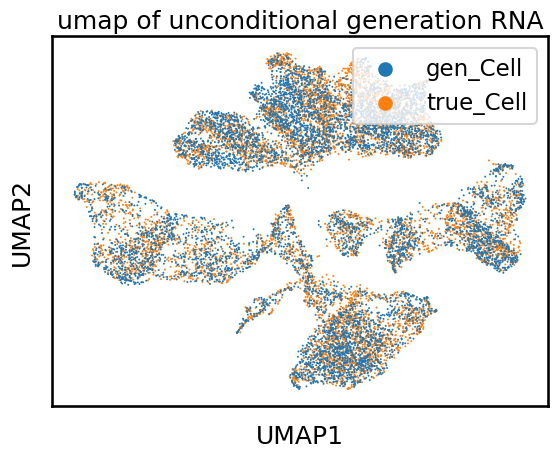

In [18]:
# # 再转回anndata便于scanpy处理
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]

# adata.obs['cell_type'] = list(mdata['rna'].obs['cell_type'][:69000:10].to_numpy())+['gen_cell']*reconstruct.shape[0]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation RNA', show=False)
plt.legend(loc = 'upper right')
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_diff&real.pdf')

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


<AxesSubplot:title={'center':'umap of generated CD4+ T activated'}, xlabel='UMAP1', ylabel='UMAP2'>

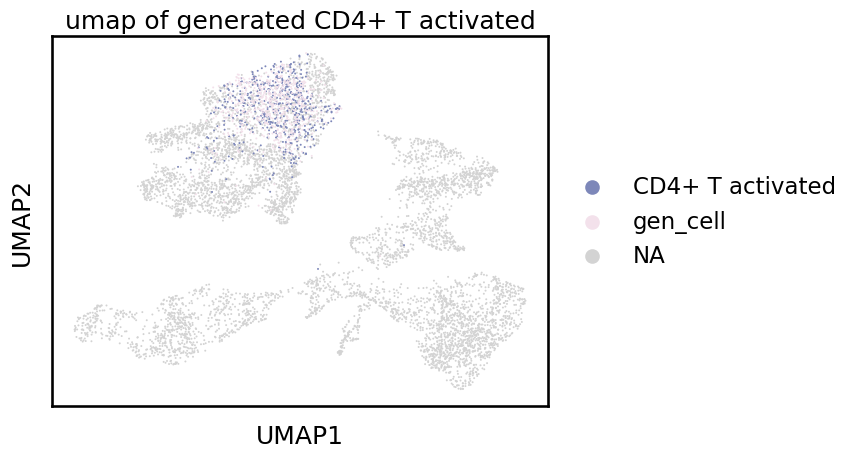

In [11]:
sc.pl.umap(adata, color='cell_type',groups=['CD4+ T activated','gen_cell'], size=8, title='umap of generated CD4+ T activated', show=False)
# plt.legend(loc = 'upper right')

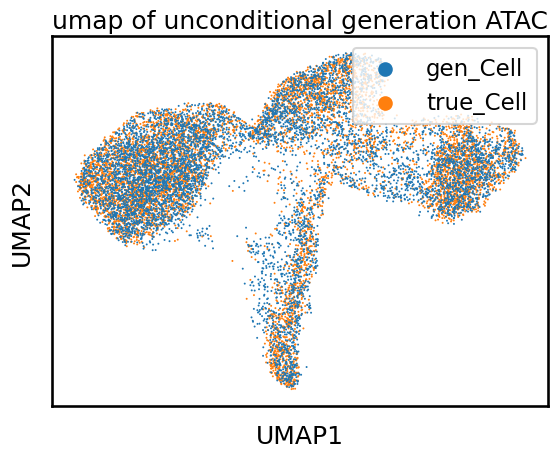

In [17]:
# # 再转回anndata便于scanpy处理
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]

sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation ATAC', show=False)
plt.legend(loc = 'upper right')
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_atac.pdf')

In [174]:
# adata = ad.AnnData(np.concatenate([real_cell2,reconstruct2,cfgen2,multivi2,peakvi2]))#
# # adata.var_names = gene_names
# adata.obs['cell_name'] = ['true_cell']*real_cell.shape[0]+['diffusion']*reconstruct.shape[0]+['cfgen']*cfgen.shape[0]+['multivi']*multivi2.shape[0]+['peakvi']*peakvi2.shape[0]

# sc.pp.normalize_total(adata, target_sum=1)

# sc.tl.pca(adata, svd_solver='arpack')
# sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
# sc.tl.umap(adata)

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure()
sc.pl.umap(adata, color='cell_name', groups=['true_cell','diffusion'],title='real cell atac',size=16,show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_atac_real&diff.pdf')
plt.figure()
sc.pl.umap(adata[adata.obs['cell_name']=='true_cell'],title='real cell atac',size=16,show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_atac_real.pdf')
plt.figure()
sc.pl.umap(adata[adata.obs['cell_name']=='diffusion'],title='diffusion generated atac',size=16,show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_atac_diffusion.pdf')
plt.figure()
sc.pl.umap(adata[adata.obs['cell_name']=='cfgen'],title='cfgen generated atac',size=16,show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_atac_cfgen.pdf')
plt.figure()
sc.pl.umap(adata[adata.obs['cell_name']=='multivi'],title='multivi generated atac',size=16,show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_atac_multivi.pdf')
plt.figure()
sc.pl.umap(adata[adata.obs['cell_name']=='peakvi'],title='peakvi generated atac',size=16,show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/open_uncondi_atac_peakvi.pdf')

# pseudo time analysis

In [127]:
# cfgen
# npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal/plots/ATAC.npz')
npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint/RNA_condi.npz')
cfgen = npzfile['data'][:real_cell.shape[0]]

npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint/ATAC_condi.npz')
cfgen2 = npzfile['data'][:real_cell.shape[0]]
# reconstruct = norm_total(reconstruct)

npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint/covariate_indices.npz')
type_cfgen = npzfile['data'][:20700][:real_cell.shape[0]]

cfgen.shape

(6925, 13431)

In [128]:
# multiVI
# npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal/plots/ATAC.npz')
npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_multi/output/rna.npz')
multivi = npzfile['data'][::1][:real_cell.shape[0]]

npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_multi/output/atac.npz')
multivi2 = npzfile['data'][::1][:real_cell.shape[0]]
# reconstruct = norm_total(reconstruct)

type_multivi = mdata['rna'][2000::1].obs['cell_type'].values[:real_cell.shape[0]]
multivi.shape

(6925, 13431)

In [130]:
# peakVI
npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_peak/output/atac.npz')
peakvi2 = npzfile['data'][::10][:real_cell.shape[0]]
# reconstruct = norm_total(reconstruct)

type_peakvi = mdata['rna'][::10].obs['cell_type'].values[:real_cell.shape[0]]

# scVI
npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_scvi/output/rna.npz')
scvi = npzfile['data'][::10][:real_cell.shape[0]]
# reconstruct = norm_total(reconstruct)

type_scvi = mdata['rna'][::10].obs['cell_type'].values[:real_cell.shape[0]]

peakvi2.shape,scvi.shape


((6925, 36553), (6925, 13431))

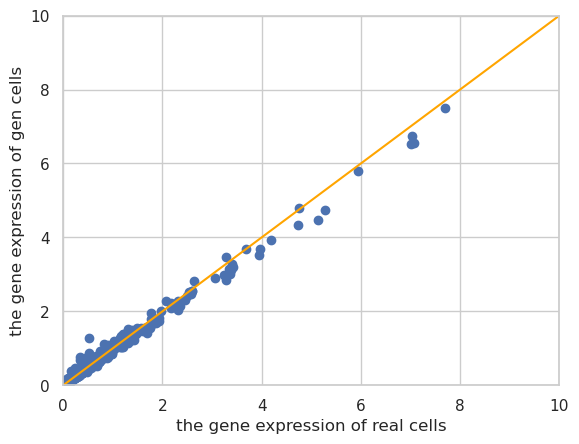

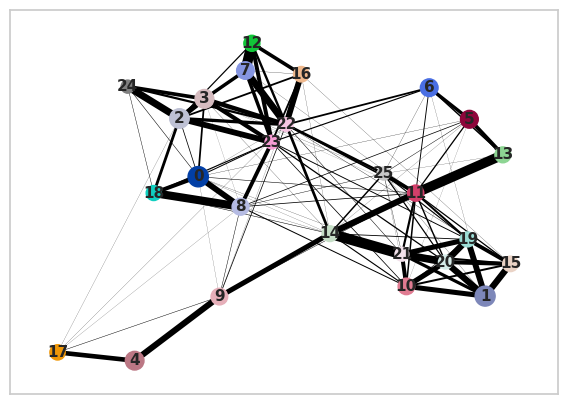

In [131]:
# # 再转回anndata便于scanpy处理
adata_real = real_cell
adata_real = ad.AnnData(adata_real, dtype=np.float32)

sc.pp.normalize_total(adata_real, target_sum=1e4)
sc.pp.log1p(adata_real)

# sc.pp.highly_variable_genes(adata_real, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata_real.raw = adata_real
# adata_real = adata_real[:, adata_real.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata_real, svd_solver='arpack')
sc.pp.neighbors(adata_real, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata_real)
# 计算PAGA初步路径
sc.tl.paga(adata_real, groups='leiden')  # 使用聚类方法如`louvain`检测群体

# 为了UMAP准备
sc.pl.paga(adata_real, plot=True)  # plot=False时生成树结构信息
sc.tl.umap(adata_real, init_pos='paga')

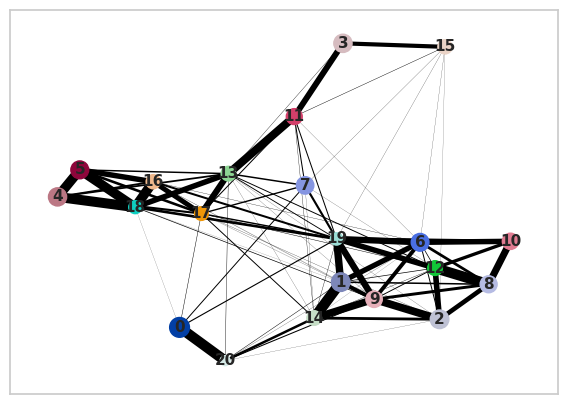

In [132]:
# # 再转回anndata便于scanpy处理
adata_recons = reconstruct
adata_recons = ad.AnnData(adata_recons, dtype=np.float32)

sc.pp.normalize_total(adata_recons, target_sum=1e4)
sc.pp.log1p(adata_recons)

# sc.pp.highly_variable_genes(adata_recons, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata_recons.raw = adata_recons
# adata_recons = adata_recons[:, adata_recons.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata_recons, svd_solver='arpack')
sc.pp.neighbors(adata_recons, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata_recons)
# 计算PAGA初步路径
sc.tl.paga(adata_recons, groups='leiden')  # 使用聚类方法如`louvain`检测群体

# 为了UMAP准备
sc.pl.paga(adata_recons, plot=True)  # plot=False时生成树结构信息
sc.tl.umap(adata_recons, init_pos='paga')

In [141]:
# 选择一个起始群体来计算伪时间
# 可通过观察 PAGA 图获知
adata_real.uns['iroot'] = np.flatnonzero(adata_real.obs['leiden'] == '17')[0]
sc.tl.dpt(adata_real)

adata_recons.uns['iroot'] = np.flatnonzero(adata_recons.obs['leiden'] == '15')[0]
sc.tl.dpt(adata_recons)

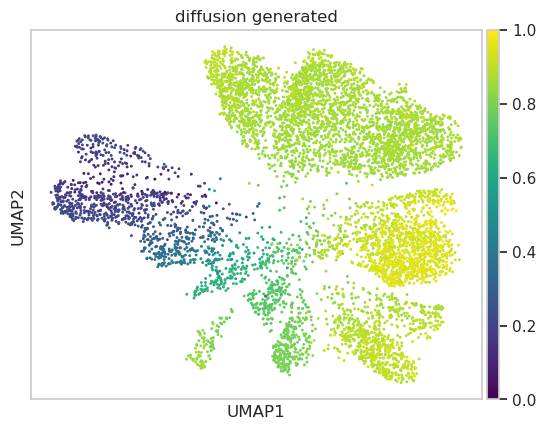

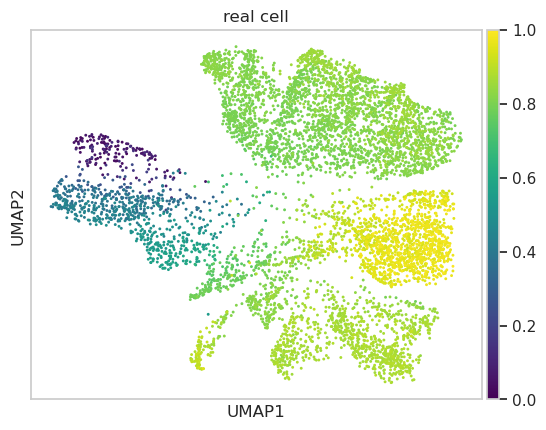

In [138]:
adata = ad.AnnData(np.concatenate([real_cell,reconstruct,cfgen,multivi,scvi]))#
adata.var_names = gene_names
adata.obs['dpt_pseudotime'] = list(adata_real.obs['dpt_pseudotime'].values)+list(adata_recons.obs['dpt_pseudotime'].values)+[-1]*cfgen.shape[0]+[-1]*multivi.shape[0]+[-1]*scvi.shape[0]
adata.obs['cell_name'] = ['true_cell']*real_cell.shape[0]+['diffusion']*reconstruct.shape[0]+['cfgen']*cfgen.shape[0]+['multivi']*multivi.shape[0]+['scvi']*scvi.shape[0]

adata.obs['leiden'] = list(adata_real.obs['leiden'].values) + list(adata_recons.obs['leiden'].values) + [-1]*cfgen.shape[0] + [-1]*multivi.shape[0] + [-1]*scvi.shape[0]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

# UMAP可视化：按伪时间着色的小区分布
dpt_pseudotime = adata.obs['dpt_pseudotime'].copy()
adata.obs.loc[adata.obs['cell_name'] != 'diffusion', 'dpt_pseudotime'] = np.nan
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata[adata.obs['cell_name']=='diffusion'], color=['dpt_pseudotime'], cmap='viridis',title='diffusion generated')#,show=False
# plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/umap/open_uncondi_diffusion.pdf')

adata.obs['dpt_pseudotime'] = dpt_pseudotime
adata.obs.loc[adata.obs['cell_name'] != 'true_cell', 'dpt_pseudotime'] = np.nan
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata[adata.obs['cell_name']=='true_cell'], color=['dpt_pseudotime'], cmap='viridis',title='real cell')#,show=False
# plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/umap/open_uncondi_real.pdf')

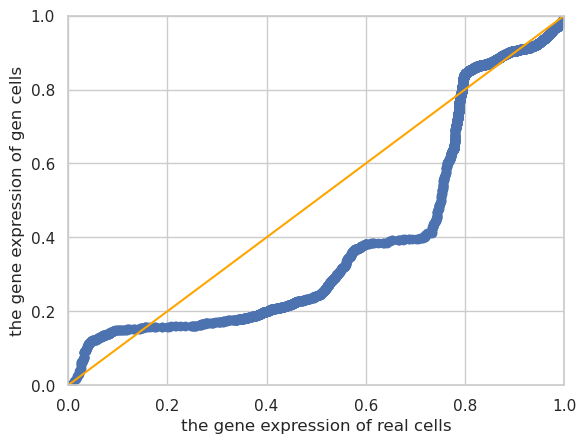

In [154]:
plt.figure()
lim = 1
plt.ylim((-0,lim))
plt.xlim((-0,lim))
plt.ylabel('the gene expression of gen cells')
plt.xlabel('the gene expression of real cells')
plt.scatter(np.sort(adata_real.obs['dpt_pseudotime'].values),np.sort(adata_recons.obs['dpt_pseudotime'].values))
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([0,lim],[0,lim],color='orange')
plt.show()

In [155]:
print('spearman=',stats.spearmanr(np.sort(adata_real.obs['dpt_pseudotime'].values),np.sort(adata_recons.obs['dpt_pseudotime'].values)).correlation)
print('pearson=',np.corrcoef(np.sort(adata_real.obs['dpt_pseudotime'].values),np.sort(adata_recons.obs['dpt_pseudotime'].values))[0][1])

spearman= 0.999999999810294
pearson= 0.9469816375784955


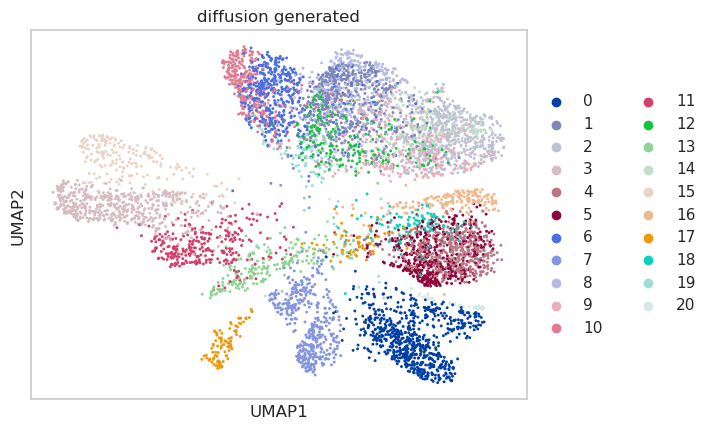

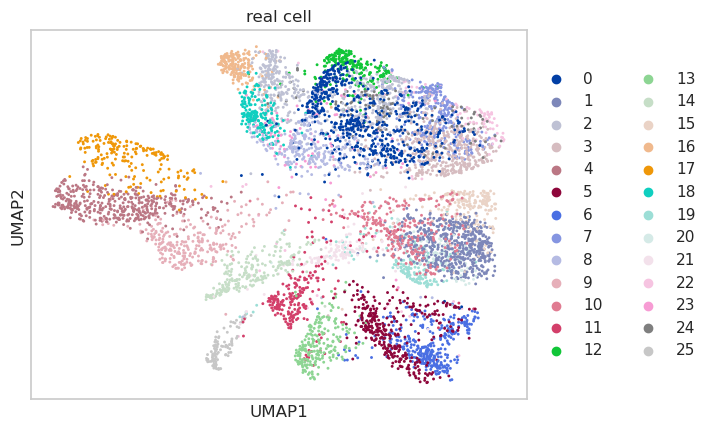

In [139]:
sc.pl.umap(adata[adata.obs['cell_name']=='diffusion'], color=['leiden'],title='diffusion generated')
sc.pl.umap(adata[adata.obs['cell_name']=='true_cell'], color=['leiden'],title='real cell')

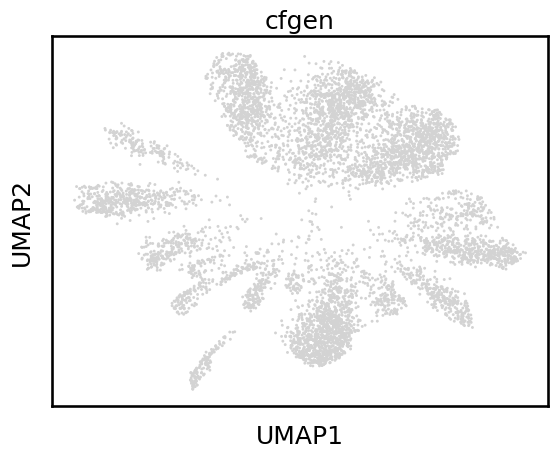

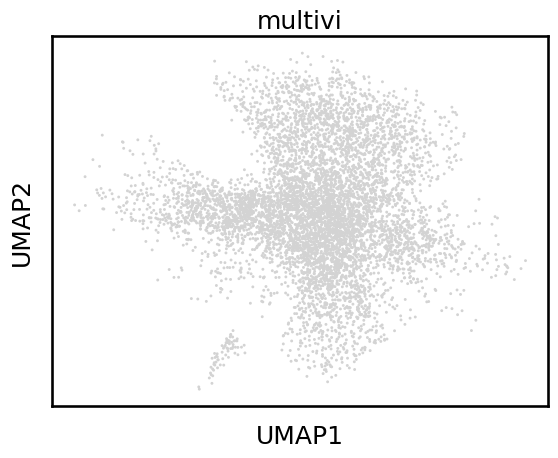

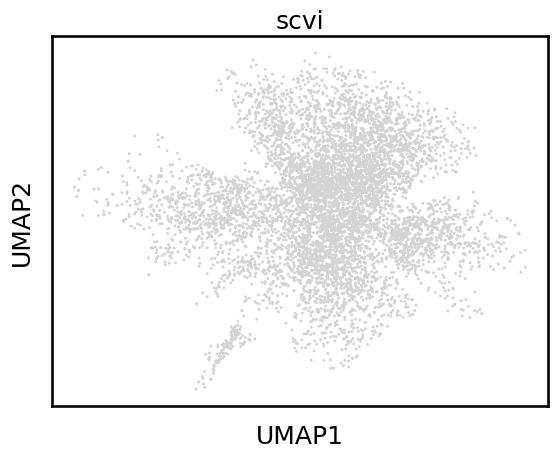

In [43]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata[adata.obs['cell_name']=='cfgen'], title='cfgen',show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/umap/open_uncondi_cfgen.pdf')

sc.pl.umap(adata[adata.obs['cell_name']=='multivi'], title='multivi',show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/umap/open_uncondi_multivi.pdf')

sc.pl.umap(adata[adata.obs['cell_name']=='scvi'], title='scvi',show=False)
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/umap/open_uncondi_scvi.pdf')


# marker gene plot

gene correlation map

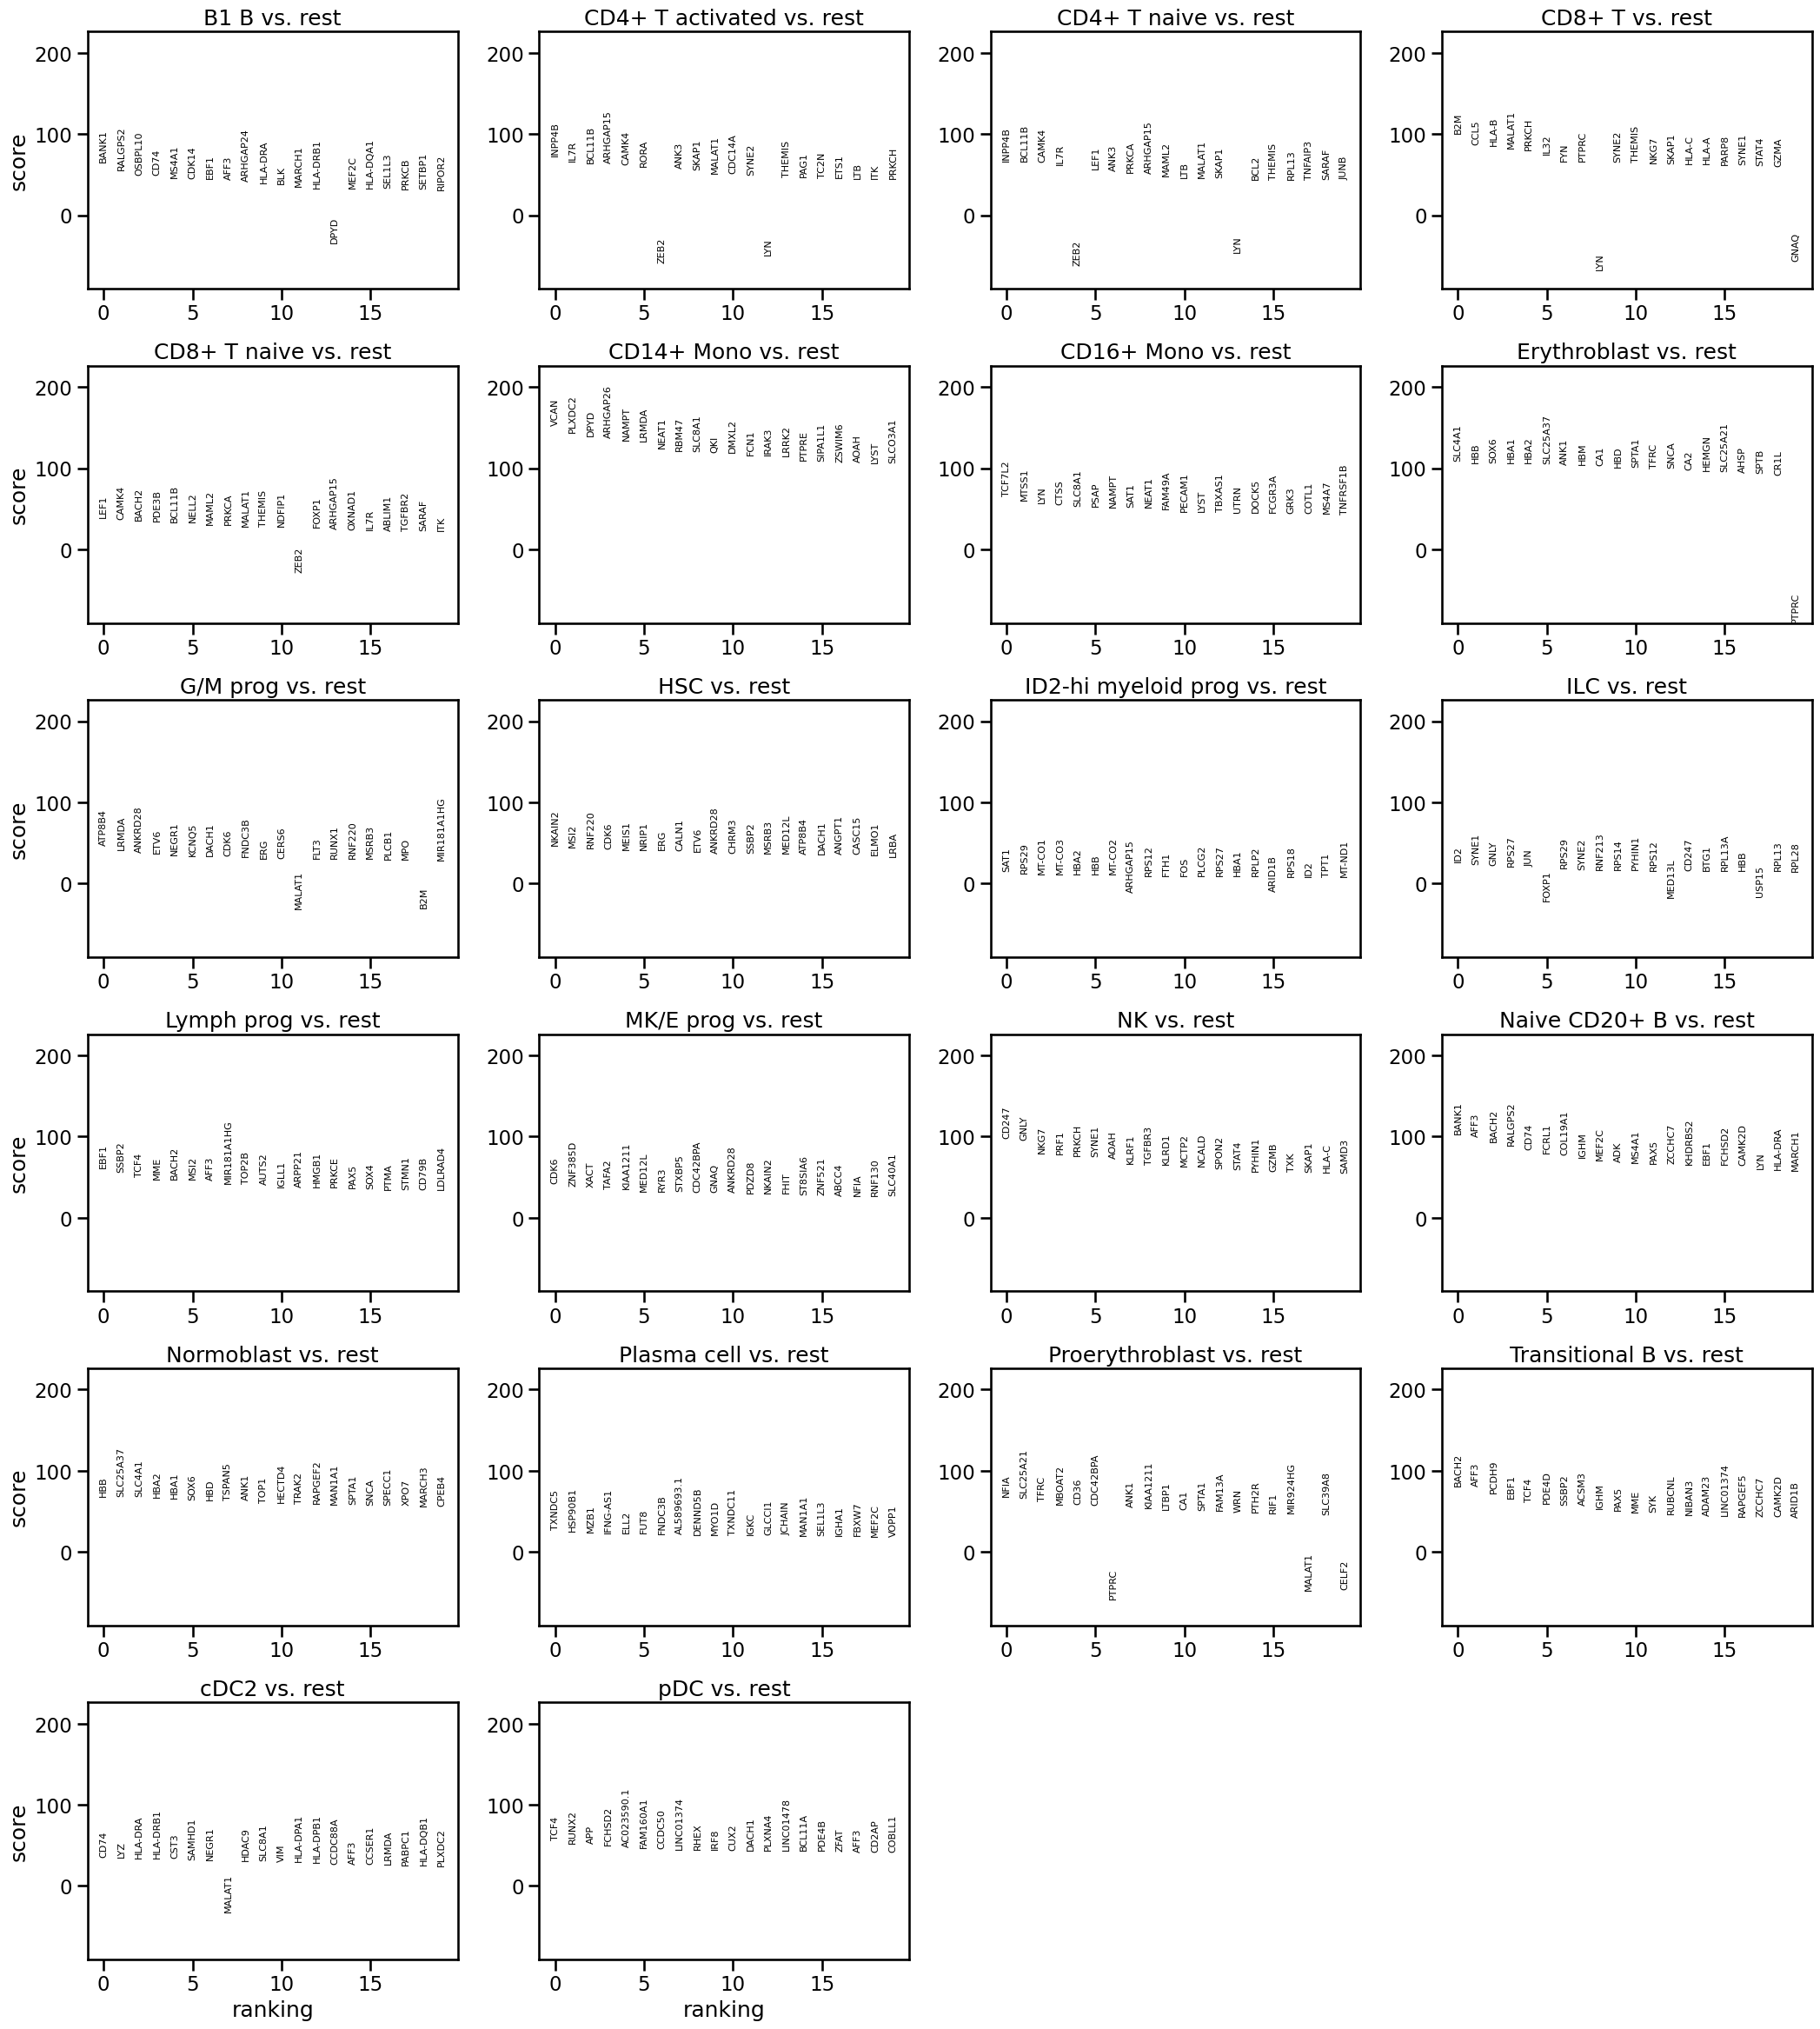

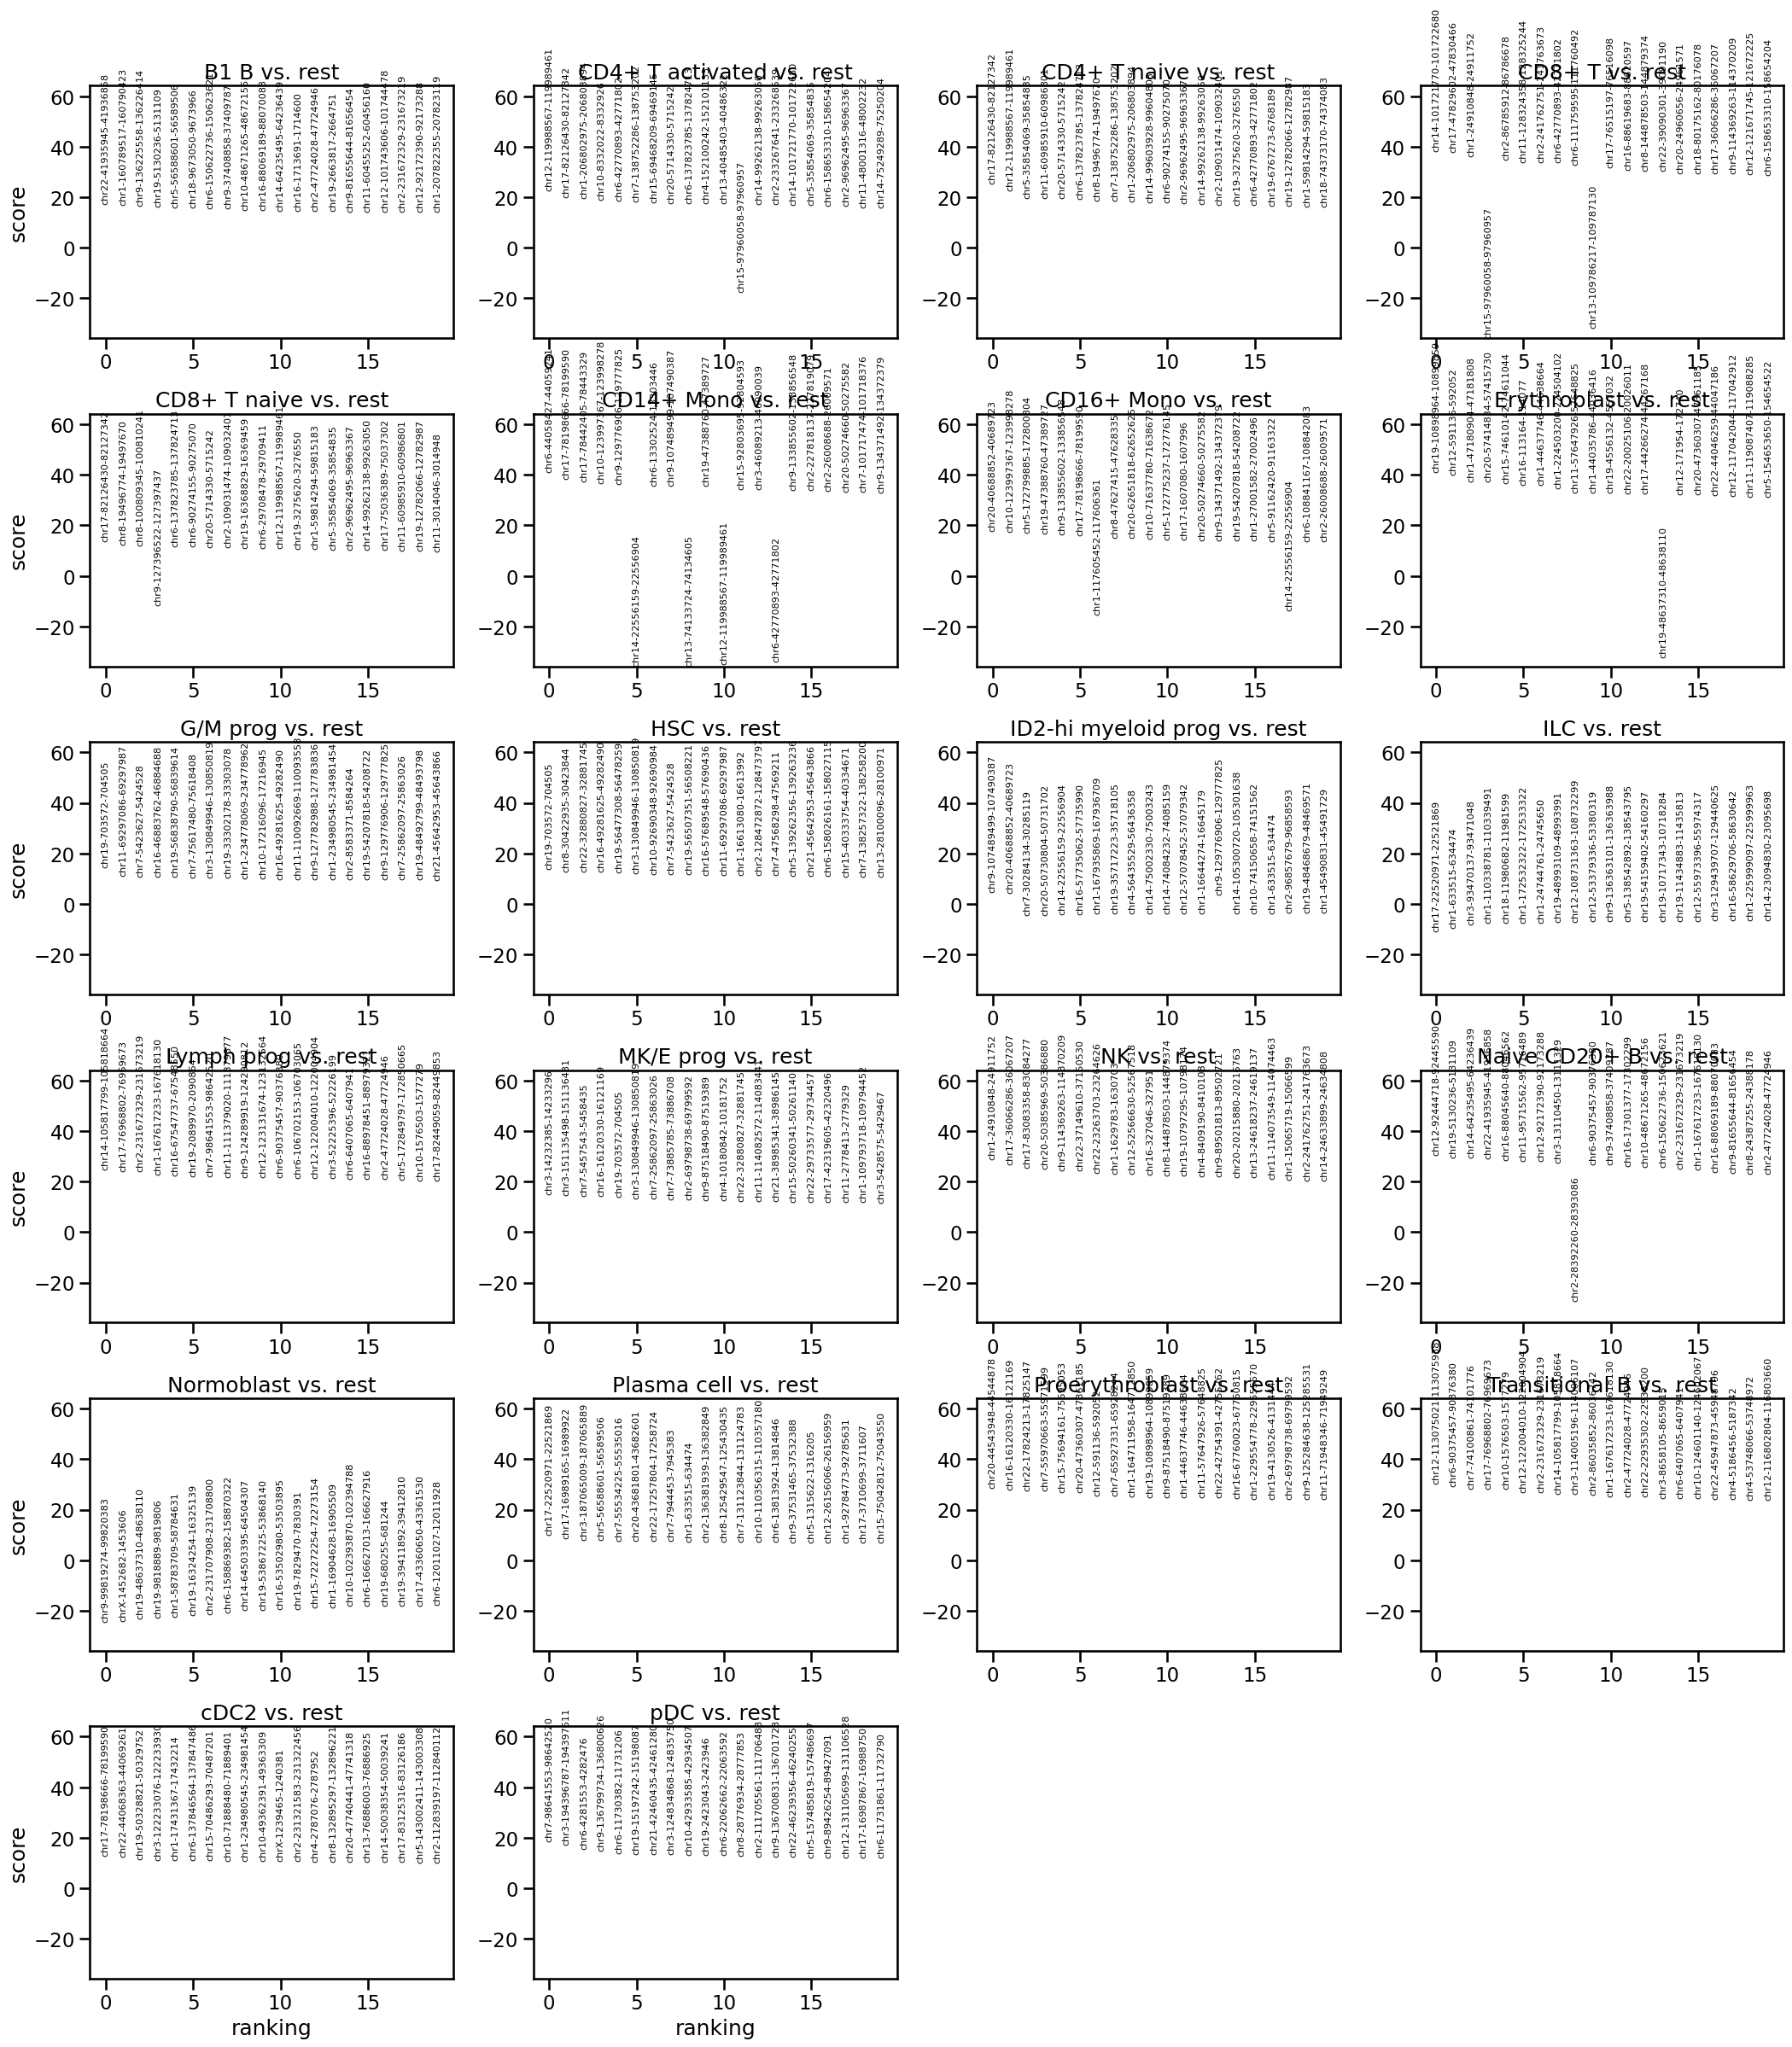

In [171]:
rna = mdata['rna']
atac = mdata['atac']

sc.pp.normalize_total(rna,1e4)
sc.pp.log1p(rna)
sc.tl.rank_genes_groups(rna,'cell_type', method='wilcoxon',rankby_abs=True) 
sc.pl.rank_genes_groups(rna)

sc.tl.rank_genes_groups(atac,'cell_type', method='wilcoxon',rankby_abs=True) 
sc.pl.rank_genes_groups(atac)


In [301]:
# reconstruct = norm_total(np.array(reconstruct),1e4)
# sc.pp.normalize_total(mdata['rna'],1e4)

index_marker = np.array([np.where(mdata['rna'].var_names.values == x)[0][0] for x in rna.uns['rank_genes_groups']['names'][0]])
real_marker = mdata['rna'][:,index_marker].X.toarray()
gen_marker = reconstruct[:, index_marker]
type_list = mdata['rna'].obs['cell_type'].values

gen_marker = [gen_marker[type_index==i].mean(0) for i in range(np.unique(type_index).shape[0])]
gen_marker = np.stack(gen_marker,axis=0)
real_marker = [real_marker[type_list==i].mean(0) for i in np.unique(type_list)]
real_marker = np.stack(real_marker,axis=0)
# real_marker.shape, gen_marker.shape
pearson_matrix = np.zeros((22,22))
for i in tqdm(range(22)):
    for j in range(22):
        if i<j:
            pearson_matrix[i,j] = np.corrcoef(real_marker[:,i], real_marker[:,j])[0][1]
        else:
            pearson_matrix[i,j] = np.corrcoef(gen_marker[:,i], gen_marker[:,j])[0][1]

100%|██████████| 22/22 [00:00<00:00, 864.35it/s]


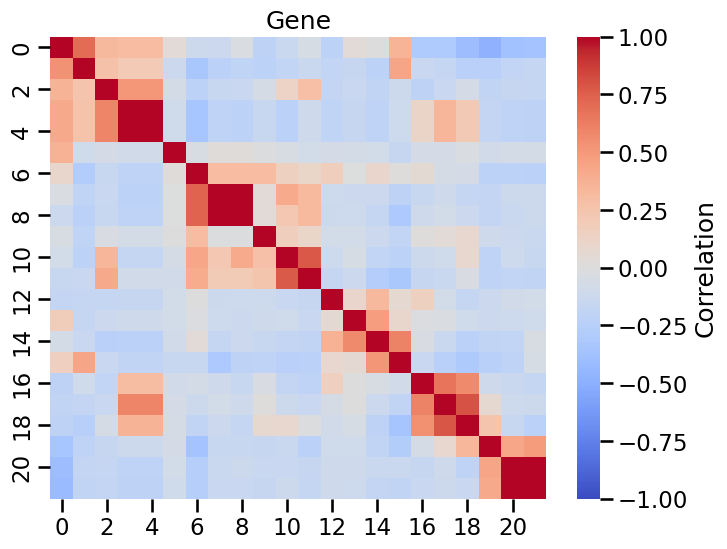

In [302]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import squareform

matrix = pearson_matrix
matrix = (matrix + matrix.T) / 2  # Symmetrize the matrix
np.fill_diagonal(matrix, 1)  # Set diagonal to 1 for correlation-like matrix

# Perform hierarchical clustering
distance_matrix = 1 - matrix  # Convert correlation to distance
condensed_distance_matrix = squareform(distance_matrix, checks=False)  # Convert to condensed form
linkage_matrix = linkage(condensed_distance_matrix, method='ward')  # Apply hierarchical clustering
ordered_indices = leaves_list(linkage_matrix)  # Get the leaf order

plt.figure(figsize=(8, 6))
# 使用seaborn绘制热图
reordered_pearson_matrix = pearson_matrix[np.ix_(ordered_indices, ordered_indices)]
sns.heatmap(reordered_pearson_matrix, 
            annot=False,         # 在方格中显示数值
            cmap='coolwarm',    # 使用蓝-红色渐变
            center=0,           # 中心值为0
            vmin=-1,            # 设置颜色条的最小值为-1
            vmax=1,             # 设置颜色条的最大值为1
            cbar_kws={'label': 'Correlation'})  # 颜色条标签

# 显示图形
plt.title('Gene')
plt.show()

In [303]:
ordered_indices

array([ 3, 14,  4,  1,  2, 17, 20,  0, 15, 21, 12, 19,  5,  6, 10, 11,  8,
        9, 13, 18,  7, 16], dtype=int32)

In [306]:
ordered_indices

array([ 3, 14,  1,  2,  4, 12, 19,  0, 15, 16, 21,  8,  9,  5, 20,  6, 10,
       11, 17,  7, 13, 18], dtype=int32)

In [304]:
index_marker = np.array([np.where(mdata['atac'].var_names.values == x)[0][0] for x in atac.uns['rank_genes_groups']['names'][0]])
real_marker = mdata['atac'][:,index_marker].X.toarray()
gen_marker = reconstruct2[:, index_marker]
type_list = mdata['rna'].obs['cell_type'].values

gen_marker = [gen_marker[type_index==i].mean(0) for i in range(np.unique(type_index).shape[0])]
gen_marker = np.stack(gen_marker,axis=0)
real_marker = [real_marker[type_list==i].mean(0) for i in np.unique(type_list)]
real_marker = np.stack(real_marker,axis=0)
# real_marker.shape, gen_marker.shape
pearson_matrix2 = np.zeros((22,22))
for i in tqdm(range(22)):
    for j in range(22):
        if i<j:
            pearson_matrix2[i,j] = np.corrcoef(real_marker[:,i], real_marker[:,j])[0][1]
        else:
            pearson_matrix2[i,j] = np.corrcoef(gen_marker[:,i], gen_marker[:,j])[0][1]

100%|██████████| 22/22 [00:00<00:00, 870.63it/s]


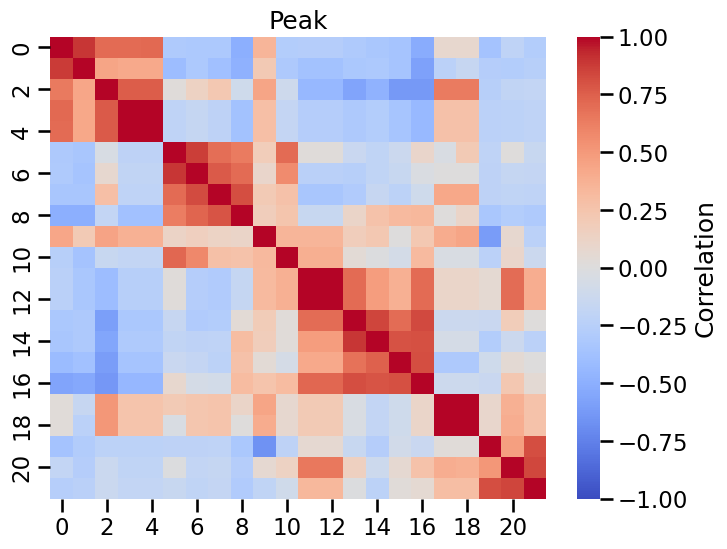

In [305]:
matrix = pearson_matrix2
matrix = (matrix + matrix.T) / 2  # Symmetrize the matrix
np.fill_diagonal(matrix, 1)  # Set diagonal to 1 for correlation-like matrix

# Perform hierarchical clustering
distance_matrix = 1 - matrix  # Convert correlation to distance
condensed_distance_matrix = squareform(distance_matrix, checks=False)  # Convert to condensed form
linkage_matrix = linkage(condensed_distance_matrix, method='ward')  # Apply hierarchical clustering
ordered_indices = leaves_list(linkage_matrix)  # Get the leaf order

plt.figure(figsize=(8, 6))
# 使用seaborn绘制热图
reordered_pearson_matrix2 = pearson_matrix2[np.ix_(ordered_indices, ordered_indices)]
sns.heatmap(reordered_pearson_matrix2, 
            annot=False,         # 在方格中显示数值
            cmap='coolwarm',    # 使用蓝-红色渐变
            center=0,           # 中心值为0
            vmin=-1,            # 设置颜色条的最小值为-1
            vmax=1,             # 设置颜色条的最大值为1
            cbar_kws={'label': 'Correlation'})  # 颜色条标签

# 显示图形
plt.title('Peak')
plt.show()

distribution

In [45]:
type_list = ['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']

In [46]:
marker_genes = {
    'CD14+ Mono': ['FCN1', 'CD14'],
    'CD16+ Mono': ['TCF7L2', 'FCGR3A', 'LYN'],
    'ID2-hi myeloid prog': ['CD14', 'ID2', 'VCAN', 'S100A9', 'CLEC12A', 'KLF4', 'PLAUR'],
    'cDC1': ['CLEC9A', 'CADM1'],
    'cDC2': ['CLEC10A', 'FCER1A', 'CST3', 'COTL1', 'LYZ', 'DMXL2'], # Note: DMXL2 should be negative
    'Reticulocyte': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'], # TFRC negative
    'Normoblast': ['SLC4A1', 'SLC25A37', 'HBB', 'HBA2', 'HBA1', 'TFRC'],  # TFRC positive
    'Erythroblast': ['MKI67', 'HBA1', 'HBB'],
    'Proerythroblast': ['CDK6', 'SYNGR1', 'HBM', 'GYPA'], # Note HBM and GYPA are negative markers   # CRACD as well, but not present in data
    'NK': ['GNLY', 'NKG7', 'CD247', 'FCER1G', 'TYROBP', 'KLRG1', 'FCGR3A'], # GRIK4 as well, but not present in data
    'ILC': ['ID2', 'PLCG2', 'GNLY', 'SYNE1'],
    'Lymph prog': ['IGLL1', 'VPREB1', 'MME', 'EBF1', 'SSBP2', 'BACH2', 'CD79B', 'IGHM', 'PAX5', 'PRKCE', 'DNTT'],  # new: STMN1
    'Naive CD20+ B':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'],
    'naive CD20+ B - IGKC-':['MS4A1', 'IL4R', 'IGHD', 'FCRL1', 'IGHM', 'IGKC'], # IGKC negative
    # 'B1 B - IGKC+':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM'],# Note IGHD and IGHM are negative markers
    'B1 B':['MS4A1', 'SSPN', 'ITGB1','IGKC', 'EPHA4', 'COL4A4', 'PRDM1', 'ZNF215', 'IRF4', 'CD38', 'XBP1', 'PAX5', 'BCL11A', 'BLK', 'IGHD', 'IGHM', 'IGKC'],# Note IGKC, IGHD and IGHM are negative markers
    'Transitional B': ['MME', 'CD38', 'CD24', 'ACSM3', 'MSI2'],
    'Plasma cell': ['MZB1', 'HSP90B1', 'FNDC3B', 'PRDM1', 'IGKC', 'JCHAIN'],
    'Plasmablast': ['XBP1', 'PRDM1', 'PAX5'],  # Note PAX5 is a negative marker   # RF4 as well, but not present in data
    'CD4+ T activated': ['CD4', 'IL7R', 'TRBC2', 'ITGB1'],
    'CD4+ T naive': ['CD4', 'IL7R', 'TRBC2', 'CCR7'],
    'CD8+ T': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'CD8+ T naive': ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA'],
    'T activation': ['CD69', 'CD38'], # CD69 much better marker!
    'T naive': ['LEF1', 'CCR7', 'TCF7'],
    'pDC': ['GZMB', 'IL3RA', 'COBLL1', 'TCF4'],
    'G/M prog': ['MPO', 'BCL2', 'KCNQ5', 'CSF3R', 'PRTN3'], 
    'HSC': ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2'], 
    'MK/E prog': ['ZNF385D', 'ITGA2B', 'PLCB1'], # 'RYR3' as well,  but not present in data
    'HSPC STMN1+':['STMN1', 'HMGB1'] # newly characterized
}

In [502]:
target_type = 9

type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label']
real_type_cell = mdata['rna'][mdata['rna'].obs['cell_type']==type_list[target_type]].X.toarray()[::4]
reconstruct_type = sample['rna'][type_index==target_type][:real_type_cell.shape[0]].detach().numpy()

npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/RNA_condi_big.npz')
cfgen = npzfile['data']
npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/covariate_indices_big.npz')
type_cfgen = npzfile['data'][:69100]
cfgen_type = cfgen[type_cfgen==target_type][:real_type_cell.shape[0]]

npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_multi/output/rna_big.npz')
multivi = npzfile['data']
type_multivi = mdata['rna'][2000:].obs['cell_type'].values
multivi_type = multivi[type_multivi==type_list[target_type]][:real_type_cell.shape[0]]

npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_scvi/output/rna.npz')
scvi = npzfile['data']
type_scvi = mdata['rna'].obs['cell_type'].values
scvi_type = scvi[type_scvi==type_list[target_type]][:real_type_cell.shape[0]]

adata = ad.AnnData(np.concatenate([real_type_cell,reconstruct_type,cfgen_type,multivi_type,scvi_type]))#
adata.var_names = gene_names
adata.obs['cell_name'] = ['true_cell']*real_type_cell.shape[0]+['diffusion']*reconstruct_type.shape[0]+['cfgen']*cfgen_type.shape[0]+['multivi']*multivi_type.shape[0]+['scvi']*scvi_type.shape[0]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

true_cell vs. diffusion: Wilcoxon test (paired samples), P_val:9.185e-01 Stat=1.736e+04
true_cell vs. cfgen: Wilcoxon test (paired samples), P_val:2.958e-05 Stat=1.261e+04
true_cell vs. multivi: Wilcoxon test (paired samples), P_val:2.800e-35 Stat=1.266e+03


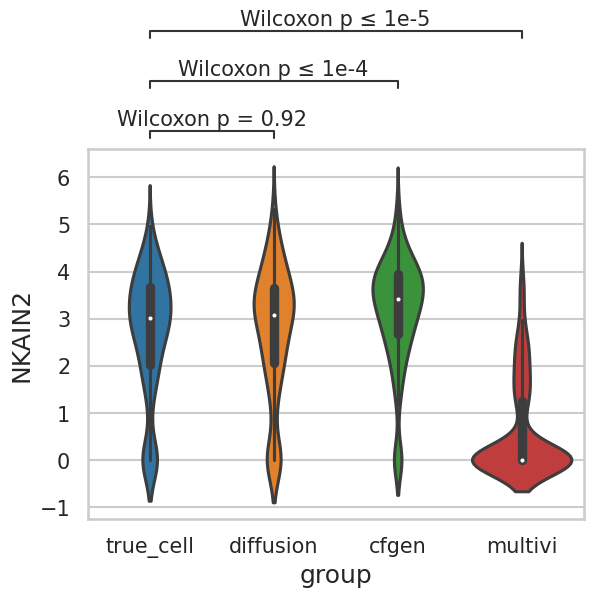

In [380]:
gene_marker = ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2']
# gene_marker = ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA']
# for gene_name in gene_marker:
gene_name = 'NKAIN2'
data = {'group':adata.obs['cell_name'],
        gene_name :adata[:,gene_name].X.toarray().squeeze(-1)}
df = pd.DataFrame(data)

x = "group"
y = gene_name
order = ['true_cell', 'diffusion', 'cfgen', 'multivi']

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure()
ax = sns.violinplot(data=df, x=x, y=y, order=order,)
# plt.ylim(-0.8, 4)

pairs=[('true_cell', 'diffusion'), ('true_cell', 'cfgen'), ('true_cell', 'multivi')]

# "barplot", "boxplot", "stripplot", "swarmplot", "violinplot"
annotator = Annotator(ax, pairs, data=df, x=x, y=y, order=order, plot='violinplot')
annotator.configure(test='Wilcoxon', text_format='simple', loc='outside')
annotator.apply_and_annotate()

plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/marker_violin/{gene_name}_{type_list[target_type]}.pdf', dpi=300, bbox_inches='tight')

In [87]:
from scipy.stats import entropy

for target_type in range(22):

    type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label']
    real_type_cell = mdata['rna'][mdata['rna'].obs['cell_type']==type_list[target_type]].X.toarray()#[::4]
    reconstruct_type = sample['rna'][type_index==target_type][:real_type_cell.shape[0]].detach().numpy()

    npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/RNA_condi_big.npz')
    cfgen = npzfile['data']
    npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/covariate_indices_big.npz')
    type_cfgen = npzfile['data'][:69100]
    cfgen_type = cfgen[type_cfgen==target_type][:real_type_cell.shape[0]]

    npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_multi/output/rna_big.npz')
    multivi = npzfile['data']
    type_multivi = mdata['rna'][2000:].obs['cell_type'].values
    multivi_type = multivi[type_multivi==type_list[target_type]][:real_type_cell.shape[0]]

    npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_scvi/output/rna.npz')
    scvi = npzfile['data']
    type_scvi = mdata['rna'].obs['cell_type'].values
    scvi_type = scvi[type_scvi==type_list[target_type]][:real_type_cell.shape[0]]

    adata = ad.AnnData(np.concatenate([real_type_cell,reconstruct_type,cfgen_type,multivi_type,scvi_type]))#
    adata.var_names = gene_names
    adata.obs['cell_name'] = ['true_cell']*real_type_cell.shape[0]+['diffusion']*reconstruct_type.shape[0]+['cfgen']*cfgen_type.shape[0]+['multivi']*multivi_type.shape[0]+['scvi']*scvi_type.shape[0]
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    gene_marker = marker_genes[type_list[target_type]]
    # gene_marker = ['NRIP1', 'MECOM', 'PROM1', 'CD34', 'NKAIN2']
    # gene_marker = ['CD8A', 'CD8B', 'GZMB', 'GZMA', 'CCL5', 'GZMK', 'GZMH', 'GZMA']
    for gene_name in gene_marker:
        # gene_name = 'NRIP1'
        try:
            data_group_1 = adata[adata.obs['cell_name']=='true_cell', gene_name].X.toarray()
        except:
            continue
        data_group_2 = adata[adata.obs['cell_name']=='diffusion', gene_name].X.toarray()
        data_group_3 = adata[adata.obs['cell_name']=='cfgen', gene_name].X.toarray()
        data_group_4 = adata[adata.obs['cell_name']=='multivi', gene_name].X.toarray()
        data_group_5 = adata[adata.obs['cell_name']=='scvi', gene_name].X.toarray()

        # 将所有数据放在一个列表中
        data_groups = [data_group_1, data_group_2, data_group_3, data_group_4, data_group_5]
        flag = 0
        for i in range(5):
            if data_groups[i].sum() == 0:
                flag=1
                break
        if flag:
            continue

        # 创建画布和子图
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 设定 1 行 4 列的子图布局
        sns.set(style="whitegrid")
        # sns.set_palette("deep")  # 选择一个特定的颜色调色板
        plt.rcParams['pdf.fonttype'] = 42
        plt.rcParams['ps.fonttype'] = 42

        # 设置每组数据的标题
        titles = ['real cell vs diffusion', 'real cell vs cfgen', 'real cell vs multivi', 'real cell vs scvi']
        methods_list = ['real cell','diffusion', 'cfgen', 'multivi', 'scvi']

        # 逐组绘制图形
        for i in range(1, 5):

            # 绘制分布图
            sns.histplot(data_groups[0].squeeze(-1), color="C0", kde=True, label=f'real cell', stat='density', bins=30, ax=axs[i - 1])
            sns.histplot(data_groups[i].squeeze(-1), color="C1", kde=True, label=methods_list[i], stat='density', bins=30, ax=axs[i - 1])

            # 计算并标记 KL 散度
            hist_group_1, _ = np.histogram(data_groups[0], bins=30, density=True)
            hist_group_i, _ = np.histogram(data_groups[i], bins=30, density=True)

            # 计算 KL 散度
            kl_divergence = entropy(hist_group_1 + 1e-10, hist_group_i + 1e-10)
            
            axs[i - 1].text(0.1, 0.6, f'KL Divergence: {kl_divergence:.2f}', fontsize=12, color='black')

            # 设置标题和标签
            axs[i - 1].set_title(titles[i - 1])
            axs[i - 1].set_xlabel('Value')
            axs[i - 1].set_ylabel(f'Density {gene_name}')
            axs[i - 1].legend()

        celltype = type_list[target_type].replace('/',' ')
        plt.tight_layout()  # 调整子图间距
        # plt.show()
        plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/marker_distribution/{celltype}_{gene_name}.pdf', dpi=300, bbox_inches='tight')
    # plt.show()

# evaluate different cell type

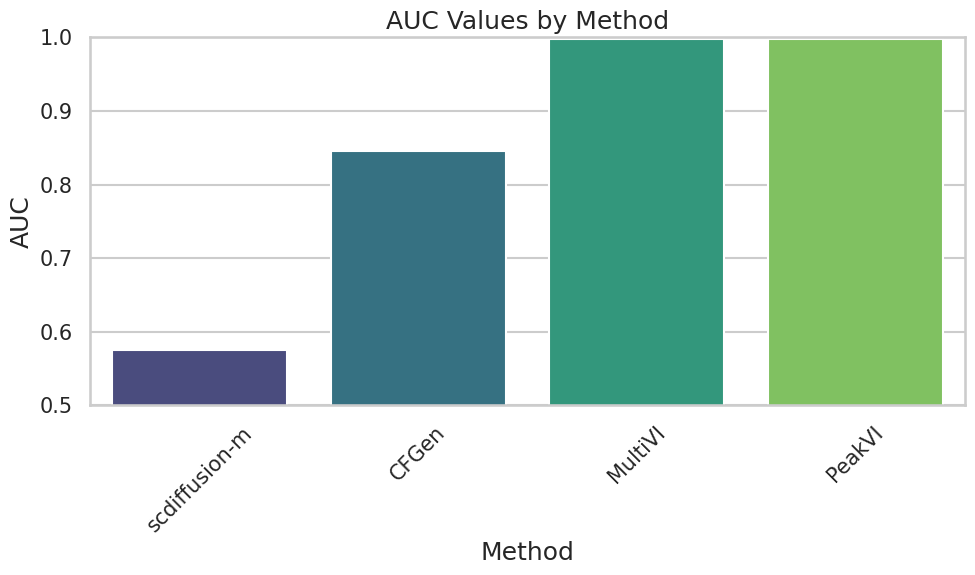

In [317]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 创建 DataFrame
key_name = 'AUC'
data = {
    'Method': ['scdiffusion-m', 'CFGen', 'MultiVI', 'PeakVI'],
    # 'PCC':    [0.99182, 0.99552, 0.95792, 0.94334]
    # key_name:    [0.99215,0.99015,0.98984,0.98984]
    # key_name:    [0.0028,0.0042,0.0161,0.0235]
    # key_name:    [0.85698,0.74166,0.60775,0.62632]
    # key_name:    [0.67554,0.75961,0.85704,0.81954]
    # key_name:    [0.99771,0.99533,0.99779,0.99348]
    # key_name:    [0.98434,0.97206,0.98172,0.96210]
    # key_name:    [0.0012,0.0290,0.0860,0.1341]
    # key_name:    [0.91879,0.79025,0.47509,0.13052]
    key_name:    [0.57526,0.84597,0.99793,0.99706]
}

df = pd.DataFrame(data)

# 用 NaN 替代缺失值
df[key_name] = df[key_name].fillna(0)  # 或者您可以选择删除缺失值或使用其他处理方法

# 绘制柱状图
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(10, 6))
sns.barplot(x='Method', y=key_name, data=df, palette='viridis')

# 设置标题和标签
plt.title(f'{key_name} Values by Method')
plt.xlabel('Method')
plt.ylabel(key_name)
plt.xticks(rotation=45)  # 旋转 x 轴标签
plt.ylim(0.5, 1)  # 确保y轴范围在0到1之间

# 显示图形
plt.tight_layout()
# plt.show()

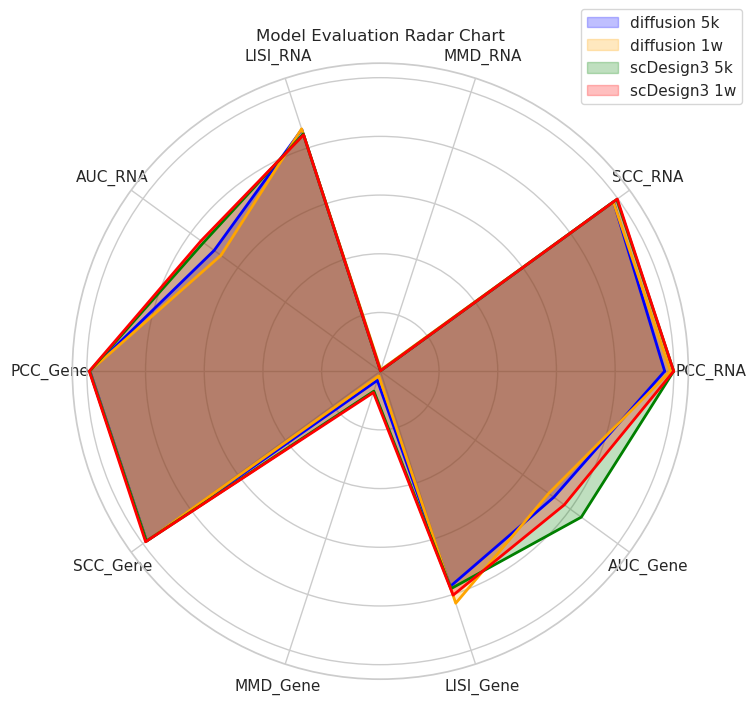

In [163]:
# compare with scDesign3
methods = ["diffusion 5k", "diffusion 1w", "scDesign3 5k", "scDesign3 1w"]

# 各个模型的指标分数
scores = np.array([
    [0.96878, 0.98183, 0.0025, 0.86609, 0.69998, 0.98929, 0.98439, 0.0330, 0.77112, 0.73052],
    [0.98859, 0.98112, 0.0049, 0.86821, 0.67149, 0.99034, 0.98493, 0.0172, 0.83131, 0.70876],
    [0.99950, 0.99577, 0.0009, 0.85007, 0.74513, 0.99057, 0.98512, 0.0716, 0.77914, 0.84621],
    [0.99943, 0.99789, 0.0011, 0.84655, 0.75539, 0.99176, 0.98875, 0.0766, 0.80235, 0.77471]
])

# 指标名称
labels = [
    'PCC_RNA', 'SCC_RNA', 'MMD_RNA', 'LISI_RNA', 
    'AUC_RNA', 'PCC_Gene', 'SCC_Gene', 'MMD_Gene', 
    'LISI_Gene', 'AUC_Gene'
]

# 设置雷达图的角度
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# 使得雷达图闭合
scores = np.concatenate((scores, scores[:, [0]]), axis=1)
angles += angles[:1]

# 绘制雷达图
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# 绘制每个模型的雷达图
colors = ['blue', 'orange', 'green', 'red']
for i, (method, score) in enumerate(zip(methods, scores)):
    ax.fill(angles, score, color=colors[i], alpha=0.25, label=method)
    ax.plot(angles, score, color=colors[i], linewidth=2)

# 设置标签和标题
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
ax.set_title('Model Evaluation Radar Chart')
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

# 展示图表
plt.show()

In [237]:
methods = ["scdiffusion-m", "CFGen", "MultiVI", "PeakVI", "scVI"]
metrics = ['PCC_RNA', 'SCC_RNA', 'MMD_RNA', 'LISI_RNA', 'AUC_RNA', 'PCC_Gene', 'SCC_Gene', 'MMD_Gene', 'LISI_Gene', 'AUC_Gene']

data_bar = np.array([
    [0.99182, 0.99215, 0.0028, 0.85698, 0.67554, 0.99771, 0.98434, 0.0012, 0.91879, 0.57526],
    [0.99552, 0.99015, 0.0042, 0.74166, 0.75961, 0.99533, 0.97206, 0.0290, 0.79025, 0.84597],
    [0.95792, 0.98984, 0.0161, 0.60775, 0.85704, 0.99779, 0.98172, 0.0860, 0.47509, 0.99793],
    [0      , 0      , 0     , 0      , 0      , 0.99348, 0.96210, 0.1341, 0.13052, 0.99706],
    [0.94334, 0.98984, 0.0235, 0.62632, 0.81954, 0      , 0      , 0     , 0      , 0      ],
])

# 绘制多个子图
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)

for i, ax in enumerate(axes):
    ax.barh(np.arange(len(methods)), data_bar[:, i][::-1], height=0.5, color='steelblue')
    ax.set_title(metrics[i])
    ax.set_yticks(np.arange(len(methods)))
    ax.set_yticklabels(methods[::-1])

    # 设置每列的范围
    if metrics[i].startswith('PCC') or metrics[i].startswith('SCC'):
        ax.set_xlim(0.93, 1.0)
    elif metrics[i].startswith('MMD'):
        ax.set_xlim(0.0, data_bar[:, i].max() * 1.1)
    elif metrics[i].startswith('LISI'):
        ax.set_xlim(0.5, 1.0)
    elif metrics[i].startswith('AUC'):
        ax.set_xlim(0.5, 1.0)

fig.suptitle("Per Metric Bar Chart with Custom Ranges")
plt.tight_layout()
# plt.show()
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/uncondi_all.pdf', dpi=300, bbox_inches='tight')

In [238]:
methods = ["scMulDiffusion 5k", "scDesign3 5k", "CFGen 5k", "MultiVI 5k", "scMulDiffusion 10k", "scDesign3 10k", "CFGen 10k", "MultiVI 10k"]
metrics = ['PCC_RNA', 'SCC_RNA', 'MMD_RNA', 'LISI_RNA', 'AUC_RNA', 'PCC_Gene', 'SCC_Gene', 'MMD_Gene', 'LISI_Gene', 'AUC_Gene']

data_bar = np.array([
    [0.96878, 0.98183, 0.0025, 0.86609, 0.69998, 0.98929, 0.98439, 0.0330, 0.77112, 0.73052],
    [0.99950, 0.99577, 0.0009, 0.85007, 0.74513, 0.99057, 0.98512, 0.0716, 0.77914, 0.84621],
    [0.98644, 0.97392, 0.0038, 0.83858, 0.71658, 0.98526, 0.97815, 0.0438, 0.80231, 0.79974],
    [0.87907, 0.99127, 0.0087, 0.77486, 0.81040, 0.99225, 0.99756, 0.2132, 0.65838, 1.0],

    [0.98859, 0.98112, 0.0049, 0.86821, 0.67149, 0.99034, 0.98493, 0.0172, 0.831313, 0.70876],
    [0.99943, 0.99789, 0.0011, 0.84655, 0.75539, 0.99176, 0.98875, 0.0766, 0.80235, 0.77471],
    [0.98103, 0.98533, 0.0023, 0.82226, 0.71060, 0.99186, 0.98762, 0.0210, 0.81505, 0.75207],
    [0.98185, 0.99430, 0.0029, 0.83373, 0.76910, 0.99595, 0.99433, 0.1854, 0.72475, 0.99999]
])

# 绘制多个子图
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)

for i, ax in enumerate(axes):
    ax.barh(np.arange(len(methods)), data_bar[:, i][::-1], height=0.5, color='steelblue')
    ax.set_title(metrics[i])
    ax.set_yticks(np.arange(len(methods)))
    ax.set_yticklabels(methods[::-1])

    # 设置每列的范围
    if metrics[i].startswith('PCC_RNA'):
        ax.set_xlim(0.8, 1.0)
    if metrics[i].startswith('PCC_Gene'):
        ax.set_xlim(0.9, 1.0)
    elif metrics[i].startswith('SCC'):
        ax.set_xlim(0.9, 1.0)
    elif metrics[i].startswith('MMD'):
        ax.set_xlim(0.0, data_bar[:, i].max() * 1.1)
    elif metrics[i].startswith('LISI'):
        ax.set_xlim(0.5, 1.0)
    elif metrics[i].startswith('AUC'):
        ax.set_xlim(0.5, 1.0)

fig.suptitle("Per Metric Bar Chart with Custom Ranges")
plt.tight_layout()
# plt.show()
plt.savefig(f'/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/uncondi_all_small.pdf', dpi=300, bbox_inches='tight')

In [182]:
from tqdm import tqdm
type_list = ['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']
columns = ['cell type', 'RNA PCC', 'RNA SCC', 'RNA MMD', 'RNA LISI', 'RNA AUC', 'ATAC PCC', 'ATAC SCC', 'ATAC MMD', 'ATAC LISI', 'ATAC AUC']
type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label']
df = pd.DataFrame(columns=columns)
for id, type in enumerate(type_list):
    total = (mdata['rna'].obs['cell_type']==type).sum()
    sample_index = np.random.choice(total, size=800, replace=False) if total>=800 else list(range(total))
    real_cell = mdata['rna'][mdata['rna'].obs['cell_type']==type].X.toarray()[sample_index]#[::7]#[:800]
    real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']==type].X.toarray()[sample_index]#[::7]#[:800]
    cell_num = min((type_index==id).sum(),real_cell.shape[0])
    reconstruct = sample['rna'][type_index==id][:cell_num].detach().numpy()
    reconstruct2 = sample['atac'][type_index==id][:cell_num].detach().numpy()
    real_cell = real_cell[:cell_num]
    real_cell2 = real_cell2[:cell_num]

    rna_scc = stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation
    rna_pcc = np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1]
    atac_scc = stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation
    atac_pcc = np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1]


    adata = np.concatenate((real_cell, reconstruct),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
    rna_mmd = MMD(adata)
    rna_lisi = LISI(adata)
    rna_auc = random_forest(adata)

    adata = np.concatenate((real_cell2, reconstruct2),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
    atac_mmd = MMD(adata)
    atac_lisi = LISI(adata)
    atac_auc = random_forest(adata)

    df.loc[id] = [type, rna_pcc, rna_scc, rna_mmd, rna_lisi, rna_auc, atac_pcc, atac_scc, atac_mmd, atac_lisi, atac_auc]

100%|██████████| 9/9 [00:00<00:00, 88.48it/s]


In [332]:
df.to_csv('eval_results/diffusion.csv', index=False)
df

cell type   RNA PCC   RNA SCC         RNA MMD  RNA LISI  \
0                  B1 B  0.987566  0.967615  tensor(0.0150)  0.833364   
1            CD14+ Mono  0.992969  0.975501  tensor(0.0269)  0.873068   
2            CD16+ Mono  0.995610  0.982333  tensor(0.0422)  0.806425   
3      CD4+ T activated  0.997701  0.972190  tensor(0.0183)  0.879269   
4          CD4+ T naive  0.997946  0.974163  tensor(0.0353)  0.839855   
5                CD8+ T  0.996127  0.969788  tensor(0.0249)  0.784428   
6          CD8+ T naive  0.995426  0.973165  tensor(0.0270)  0.806572   
7          Erythroblast  0.998432  0.977005  tensor(0.0042)  0.922589   
8              G/M prog  0.981477  0.979162  tensor(0.0316)  0.823997   
9                   HSC  0.987696  0.978155  tensor(0.0364)  0.797329   
10  ID2-hi myeloid prog  0.923833  0.735099  tensor(0.4095)  0.716665   
11                  ILC  0.990462  0.960589  tensor(0.0322)  0.820974   
12           Lymph prog  0.981817  0.973881  tensor(0.0234)  0.857090   
13            MK/E prog  0.960135  0.977791  tensor(0.0424)  0.786968   
14                   NK  0.994365  0.972740  tensor(0.0311)  0.768475   
15        Naive CD20+ B  0.993580  0.960503  tensor(0.0211)  0.830556   
16           Normoblast  0.997995  0.933665  tensor(0.0201)  0.905464   
17          Plasma cell  0.959082  0.961674  tensor(0.0229)  0.837189   
18      Proerythroblast  0.982554  0.984298  tensor(0.0107)  0.861554   
19       Transitional B  0.990861  0.954412  tensor(0.0442)  0.873715   
20                 cDC2  0.980364  0.979903  tensor(0.0208)  0.853975   
21                  pDC  0.982402  0.980236  tensor(0.0911)  0.779413   

     RNA AUC  ATAC PCC  ATAC SCC        ATAC MMD  ATAC LISI  ATAC AUC  
0   0.797694  0.986721  0.979733  tensor(0.0106)   0.899214  0.595788  
1   0.677646  0.981683  0.975874  tensor(0.0077)   0.905203  0.597564  
2   0.786214  0.982685  0.974554  tensor(0.0622)   0.847424  0.660114  
3   0.670718  0.988320  0.978231  tensor(0.0072)   0.888342  0.633578  
4   0.745648  0.989293  0.979403  tensor(0.0133)   0.877567  0.604692  
5   0.730742  0.987550  0.979525  tensor(0.0238)   0.911457  0.639081  
6   0.658188  0.990184  0.981577  tensor(0.0188)   0.891647  0.647134  
7   0.734019  0.989771  0.966028  tensor(0.0187)   0.886622  0.719638  
8   0.794243  0.981967  0.969076  tensor(0.0131)   0.892188  0.690201  
9   0.767057  0.983788  0.974396  tensor(0.0166)   0.853439  0.715586  
10  0.837321  0.873203  0.788035  tensor(0.0468)   0.924559  0.488038  
11  0.752227  0.983203  0.964551  tensor(0.0125)   0.911292  0.629204  
12  0.731117  0.986919  0.980634  tensor(0.0418)   0.869461  0.688000  
13  0.773459  0.985934  0.977077  tensor(0.0206)   0.876386  0.718487  
14  0.754477  0.987499  0.977424  tensor(0.0165)   0.885925  0.563350  
15  0.647759  0.985722  0.975846  tensor(0.0122)   0.894257  0.629877  
16  0.724090  0.985125  0.915431  tensor(0.0624)   0.840820  0.642357  
17  0.833270  0.979633  0.963814  tensor(0.0197)   0.901915  0.604934  
18  0.727941  0.988878  0.981070  tensor(0.0146)   0.894323  0.668142  
19  0.750600  0.985322  0.980596  tensor(0.0225)   0.887747  0.643908  
20  0.712523  0.983508  0.973885  tensor(0.0151)   0.909913  0.697812  
21  0.822079  0.986729  0.976973  tensor(0.0178)   0.879067  0.674945

In [184]:
from tqdm import tqdm
type_list = ['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']
columns = ['cell type', 'RNA PCC', 'RNA SCC', 'RNA MMD', 'RNA LISI', 'RNA AUC', 'ATAC PCC', 'ATAC SCC', 'ATAC MMD', 'ATAC LISI', 'ATAC AUC']
df2 = pd.DataFrame(columns=columns)

npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/covariate_indices_big.npz')
type_index = npzfile['data'][:69100]
npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/RNA_condi_big.npz')
sample_cfgen = npzfile['data']#[:20000]#[np.where(index==3)][:real_cell.shape[0]]
npzfile = np.load('/stor/lep/workspace/multi_diffusion/CFGen/project_folder/experiments/fm_resnet_autoencoder_openproblem_multimodal_joint_2/ATAC_condi_big.npz')
sample2_cfgen = npzfile['data']#[:20000]#[np.where(index==3)][:real_cell.shape[0]]


for id, type in enumerate(type_list):
    total = (mdata['rna'].obs['cell_type']==type).sum()
    sample_index = np.random.choice(total, size=800, replace=False) if total>=800 else list(range(total))
    real_cell = mdata['rna'][mdata['rna'].obs['cell_type']==type].X.toarray()[sample_index]#[::7]#[:800]
    real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']==type].X.toarray()[sample_index]#[::7]#[:800]
    cell_num = min((type_index==id).sum(),real_cell.shape[0])
    reconstruct = sample_cfgen[type_index==id][:cell_num]
    reconstruct2 = sample2_cfgen[type_index==id][:cell_num]
    real_cell = real_cell[:cell_num]
    real_cell2 = real_cell2[:cell_num]

    rna_scc = stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation
    rna_pcc = np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1]
    atac_scc = stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation
    atac_pcc = np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1]


    adata = np.concatenate((real_cell, reconstruct),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
    rna_mmd = MMD(adata)
    rna_lisi = LISI(adata)
    rna_auc = random_forest(adata)

    adata = np.concatenate((real_cell2, reconstruct2),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
    atac_mmd = MMD(adata)
    atac_lisi = LISI(adata)
    atac_auc = random_forest(adata)

    df2.loc[id] = [type, rna_pcc, rna_scc, rna_mmd, rna_lisi, rna_auc, atac_pcc, atac_scc, atac_mmd, atac_lisi, atac_auc]

100%|██████████| 9/9 [00:00<00:00, 103.64it/s]


In [185]:
df2.to_csv('eval_results/cfgen.csv', index=False)
df2

cell type   RNA PCC   RNA SCC         RNA MMD  RNA LISI  \
0                  B1 B  0.988784  0.966697  tensor(0.0241)  0.785186   
1            CD14+ Mono  0.996814  0.973959  tensor(0.0309)  0.845726   
2            CD16+ Mono  0.995311  0.979192  tensor(0.0313)  0.739658   
3      CD4+ T activated  0.997450  0.968831  tensor(0.0266)  0.812609   
4          CD4+ T naive  0.990126  0.969168  tensor(0.0820)  0.664691   
5                CD8+ T  0.989388  0.962674  tensor(0.0568)  0.706832   
6          CD8+ T naive  0.993737  0.969793  tensor(0.0590)  0.713047   
7          Erythroblast  0.996993  0.976496  tensor(0.0484)  0.777763   
8              G/M prog  0.981314  0.975983  tensor(0.0443)  0.515234   
9                   HSC  0.982966  0.977703  tensor(0.0383)  0.671098   
10  ID2-hi myeloid prog  0.912058  0.776363  tensor(0.4613)  0.684877   
11                  ILC  0.995757  0.960307  tensor(0.0332)  0.755774   
12           Lymph prog  0.973578  0.970727  tensor(0.0345)  0.640367   
13            MK/E prog  0.969567  0.979464  tensor(0.0536)  0.631995   
14                   NK  0.992940  0.970788  tensor(0.0449)  0.705324   
15        Naive CD20+ B  0.985367  0.959432  tensor(0.0199)  0.801943   
16           Normoblast  0.999750  0.928481  tensor(0.1086)  0.795346   
17          Plasma cell  0.820825  0.947767  tensor(0.1823)  0.602664   
18      Proerythroblast  0.961846  0.983974  tensor(0.0246)  0.697316   
19       Transitional B  0.992928  0.952561  tensor(0.0367)  0.809031   
20                 cDC2  0.965024  0.975800  tensor(0.0922)  0.571899   
21                  pDC  0.993502  0.976457  tensor(0.0434)  0.737389   

     RNA AUC  ATAC PCC  ATAC SCC        ATAC MMD  ATAC LISI  ATAC AUC  
0   0.836560  0.985012  0.979748  tensor(0.0347)   0.839609  0.795143  
1   0.829557  0.977509  0.971657  tensor(0.0172)   0.897861  0.762930  
2   0.832308  0.981336  0.974768  tensor(0.0219)   0.850148  0.758178  
3   0.834034  0.985451  0.975971  tensor(0.0264)   0.846116  0.795368  
4   0.811249  0.986231  0.977273  tensor(0.0463)   0.807719  0.810649  
5   0.811550  0.985711  0.978026  tensor(0.0293)   0.806666  0.785114  
6   0.868798  0.988002  0.980508  tensor(0.0324)   0.850734  0.790091  
7   0.891532  0.986947  0.965213  tensor(0.0423)   0.785486  0.875225  
8   0.888205  0.977075  0.960600  tensor(0.0538)   0.782595  0.830832  
9   0.881027  0.982619  0.975285  tensor(0.0348)   0.785542  0.816827  
10  0.909091  0.897373  0.824534  tensor(0.2042)   0.853851  0.743146  
11  0.866397  0.981552  0.963251  tensor(0.0344)   0.861514  0.742472  
12  0.902411  0.983780  0.977606  tensor(0.1390)   0.705216  0.870248  
13  0.895183  0.983906  0.977406  tensor(0.0417)   0.770150  0.792992  
14  0.813450  0.984683  0.974832  tensor(0.0224)   0.893048  0.750800  
15  0.831833  0.984418  0.977389  tensor(0.0239)   0.827522  0.851641  
16  0.885529  0.984538  0.920404  tensor(0.0661)   0.751224  0.777686  
17  0.967810  0.973301  0.956311  tensor(0.0951)   0.801510  0.831724  
18  0.849540  0.985869  0.980566  tensor(0.0864)   0.798874  0.857218  
19  0.839061  0.984237  0.979959  tensor(0.0283)   0.784432  0.807623  
20  0.893707  0.981658  0.972211  tensor(0.0812)   0.834271  0.840811  
21  0.863170  0.984347  0.975668  tensor(0.0257)   0.849931  0.756853

In [186]:
from tqdm import tqdm
type_list = ['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']
columns = ['cell type', 'RNA PCC', 'RNA SCC', 'RNA MMD', 'RNA LISI', 'RNA AUC', 'ATAC PCC', 'ATAC SCC', 'ATAC MMD', 'ATAC LISI', 'ATAC AUC']
df3 = pd.DataFrame(columns=columns)

npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_multi/output/rna_big.npz')
sample_multivi = npzfile['data']
npzfile = np.load('/stor/lep/workspace/multi_diffusion/MultiVI/open_multi/output/atac_big.npz')
sample2_multivi = npzfile['data']

type_index = mdata['rna'][2000:].obs['cell_type'].values

for id, type in enumerate(type_list):
    total = (mdata['rna'].obs['cell_type']==type).sum()
    sample_index = np.random.choice(total, size=800, replace=False) if total>=800 else list(range(total))
    real_cell = mdata['rna'][mdata['rna'].obs['cell_type']==type].X.toarray()[sample_index]#[::7]#[:800]
    real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']==type].X.toarray()[sample_index]#[::7]#[:800]
    cell_num = min((type_index==type).sum(),real_cell.shape[0])
    reconstruct = sample_multivi[type_index==type][:cell_num]
    reconstruct2 = sample2_multivi[type_index==type][:cell_num]
    real_cell = real_cell[:cell_num]
    real_cell2 = real_cell2[:cell_num]

    rna_scc = stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation
    rna_pcc = np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1]
    atac_scc = stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation
    atac_pcc = np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1]


    adata = np.concatenate((real_cell, reconstruct),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
    rna_mmd = MMD(adata)
    rna_lisi = LISI(adata)
    rna_auc = random_forest(adata)

    adata = np.concatenate((real_cell2, reconstruct2),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
    atac_mmd = MMD(adata)
    atac_lisi = LISI(adata)
    atac_auc = random_forest(adata)

    df3.loc[id] = [type, rna_pcc, rna_scc, rna_mmd, rna_lisi, rna_auc, atac_pcc, atac_scc, atac_mmd, atac_lisi, atac_auc]

100%|██████████| 9/9 [00:00<00:00, 47.84it/s]


In [187]:
df3.to_csv('eval_results/multi_vi.csv', index=False)
df3

cell type   RNA PCC   RNA SCC         RNA MMD  RNA LISI  \
0                  B1 B  0.960870  0.942128  tensor(0.1596)  0.439299   
1            CD14+ Mono  0.933579  0.940751  tensor(0.3311)  0.366150   
2            CD16+ Mono  0.951414  0.942164  tensor(0.2814)  0.428419   
3      CD4+ T activated  0.978009  0.941837  tensor(0.1236)  0.731298   
4          CD4+ T naive  0.967314  0.929063  tensor(0.1324)  0.652768   
5                CD8+ T  0.974766  0.937183  tensor(0.2282)  0.559343   
6          CD8+ T naive  0.964159  0.920787  tensor(0.1420)  0.552345   
7          Erythroblast  0.939024  0.906259  tensor(0.2701)  0.443736   
8              G/M prog  0.890547  0.922325  tensor(0.3307)  0.313983   
9                   HSC  0.901043  0.929511  tensor(0.2892)  0.274029   
10  ID2-hi myeloid prog  0.895045  0.688967  tensor(0.5997)  0.531129   
11                  ILC  0.972935  0.927109  tensor(0.0991)  0.725933   
12           Lymph prog  0.929817  0.944362  tensor(0.3289)  0.418195   
13            MK/E prog  0.869609  0.916136  tensor(0.1649)  0.311808   
14                   NK  0.957675  0.941868  tensor(0.3393)  0.432355   
15        Naive CD20+ B  0.944724  0.938997  tensor(0.4455)  0.415414   
16           Normoblast  0.920380  0.907190  tensor(0.7124)  0.295806   
17          Plasma cell  0.437264  0.937382  tensor(0.3296)  0.312952   
18      Proerythroblast  0.937640  0.882116  tensor(0.1973)  0.513204   
19       Transitional B  0.910449  0.926728  tensor(0.4178)  0.224118   
20                 cDC2  0.868013  0.950864  tensor(0.2296)  0.399958   
21                  pDC  0.918738  0.956917  tensor(0.3786)  0.260480   

     RNA AUC  ATAC PCC  ATAC SCC        ATAC MMD  ATAC LISI  ATAC AUC  
0   0.947554  0.969505  0.953088  tensor(0.2501)   0.663844  0.999450  
1   0.923669  0.953113  0.940965  tensor(0.3416)   0.631152  1.000000  
2   0.957533  0.957217  0.944792  tensor(0.2419)   0.669223  1.000000  
3   0.921569  0.980271  0.953990  tensor(0.3028)   0.748398  0.999950  
4   0.954082  0.981318  0.957190  tensor(0.3114)   0.665799  1.000000  
5   0.931748  0.978180  0.958524  tensor(0.4301)   0.643693  0.999475  
6   0.972664  0.970644  0.935785  tensor(0.2374)   0.407225  0.999625  
7   0.952431  0.950937  0.897212  tensor(0.4847)   0.302759  0.999775  
8   0.971038  0.956724  0.902145  tensor(0.2963)   0.441514  0.998975  
9   0.973114  0.952645  0.912193  tensor(0.3015)   0.297737  0.999200  
10  0.954545  0.881178  0.804308  tensor(1.1925)   0.818915  1.000000  
11  0.937600  0.980223  0.958820  tensor(0.2512)   0.709151  1.000000  
12  0.959259  0.954575  0.927435  tensor(0.2833)   0.448079  0.998724  
13  0.970638  0.953512  0.905359  tensor(0.3170)   0.382965  0.999525  
14  0.952256  0.983127  0.970985  tensor(0.5132)   0.664536  1.000000  
15  0.978491  0.962003  0.943432  tensor(0.3412)   0.515765  1.000000  
16  0.966987  0.936624  0.874033  tensor(0.5271)   0.265030  0.999950  
17  0.928718  0.973379  0.954052  tensor(0.2707)   0.658388  1.000000  
18  0.965586  0.944623  0.917516  tensor(0.3404)   0.370509  0.996048  
19  0.966937  0.946476  0.931357  tensor(0.3465)   0.374749  0.999950  
20  0.925195  0.957651  0.929943  tensor(0.2806)   0.514960  0.999775  
21  0.962060  0.964486  0.941616  tensor(0.2365)   0.428298  0.998649

In [208]:
#comparison
import matplotlib
import matplotlib.ticker as mticker
sns.set_style("whitegrid")
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
matplotlib.rcParams.update({'font.size': 15})
colors = sns.husl_palette(6, s=.8)
c1 = (249/256.,233/256.,235/256.)#pink
c2 = (238/256.,121/256.,7/256.)#orange
c3 = (45/256.,166/256.,33/256.)#green
c4 = (46/256.,125/256.,184/256.)#blue
c5 = (220/256.,0,0)#red
yticks_dic = {}
for i,type in enumerate(type_list):
    yticks_dic[i] = type

def update_ticks(x, pos):
    if x in y_methods:
        return yticks_dic[x]

lisi_rna_diffusion = df['RNA LISI']
lisi_rna_cfgen = df2['RNA LISI']
lisi_rna_multivi = df3['RNA LISI']

auc_rna_diffusion = df['RNA AUC']
auc_rna_cfgen = df2['RNA AUC']
auc_rna_multivi = df3['RNA AUC']

# mmd_rna_diffusion = np.log10(df['RNA MMD']+1)
# mmd_rna_cfgen = np.log10(df2['RNA MMD']+1)
# mmd_rna_multivi = np.log10(df3['RNA MMD']+1)
mmd_rna_diffusion = df['RNA MMD']
mmd_rna_cfgen = df2['RNA MMD']
mmd_rna_multivi = df3['RNA MMD']

# y_methods = [7,6,5,4,3,2,1,0]
y_methods = list(range(21, -1, -1))
# def cmp_plot(x_nmi,x_ari,x_homo,save):
#     plt.rcParams['pdf.fonttype'] = 42
#     plt.rcParams['ps.fonttype'] = 42
#     fig, ax = plt.subplots(figsize=(6, 9))
#     markersize = 15
#     #>:right trianger, o:circle, s:square,*:star
#     ax.plot(x_homo,y_methods, 'b>',markersize=markersize,markerfacecolor=c2,markeredgewidth=0, label='multivi')
#     ax.plot(x_ari,y_methods, 'b>',markersize=markersize,markerfacecolor=c3,markeredgewidth=0, label='cfgen')
#     ax.plot(x_nmi,y_methods, 'b>',markersize=markersize,markerfacecolor=c4,markeredgewidth=0, label='diffusion')

#     ax.set_yticks(y_methods)
#     ax.set_yticklabels([yticks_dic[i] for i in y_methods])  # Use your dictionary to set y ticks labels
#     ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
#     # plt.xlim(0-0.05,1+0.05)
#     plt.legend()
#     plt.savefig(save,format='pdf', bbox_inches='tight',dpi=600)
#     plt.show()
def cmp_plot(x_nmi, x_ari, x_homo, save):
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 15

    # 将数据整理为列表和对应的标签
    x_values = [np.array(x_nmi), np.array(x_ari), np.array(x_homo)]
    y_values = [y_methods] * len(x_values)  # y值保持不变
    colors = [c4, c3, c2]
    labels = ['diffusion', 'cfgen', 'multivi']

    # 创建一个列表以存储每个值的索引和对应的 x 值，使用 mean 进行排序
    sorted_data = sorted(zip(x_values, y_values, colors, labels), key=lambda item: np.mean(item[0]))

    # 解包排序后的数据
    sorted_x_values, sorted_y_values, sorted_colors, sorted_labels = zip(*sorted_data)

    # 绘制图形
    for x, y, color, label in zip(sorted_x_values, sorted_y_values, sorted_colors, sorted_labels):
        ax.plot(x, y, 'b>', markersize=markersize, markerfacecolor=color, markeredgewidth=0, label=label)

    ax.set_yticks(y_methods)
    ax.set_yticklabels([yticks_dic[i] for i in y_methods])  # 使用字典设置 y 轴标签
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    # 设置 x 轴的范围，确保较大的值在左边，较小的值在右边
    ax.set_xlim(max(np.concatenate(sorted_x_values)) + 0.05, min(np.concatenate(sorted_x_values)) - 0.05)

    plt.legend()
    plt.savefig(save, format='pdf', bbox_inches='tight', dpi=600)
    # plt.show()

# cmp_plot(lisi_rna_diffusion,lisi_rna_cfgen,lisi_rna_multivi,save='/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/lisi_celltype.pdf')
cmp_plot(auc_rna_diffusion,auc_rna_cfgen,auc_rna_multivi,save='/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/auc_celltype_2.pdf')
# cmp_plot(mmd_rna_diffusion,mmd_rna_cfgen,mmd_rna_multivi,save='/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/mmd_celltype.pdf')

In [207]:
yticks_dic = {}
for i,type in enumerate(type_list):
    yticks_dic[i] = type

def update_ticks(x, pos):
    if x in y_methods:
        return yticks_dic[x]

lisi_rna_diffusion = df['ATAC LISI']
lisi_rna_cfgen = df2['ATAC LISI']
lisi_rna_multivi = df3['ATAC LISI']

auc_rna_diffusion = df['ATAC AUC']
auc_rna_cfgen = df2['ATAC AUC']
auc_rna_multivi = df3['ATAC AUC']

mmd_rna_diffusion = df['ATAC MMD']
mmd_rna_cfgen = df2['ATAC MMD']
mmd_rna_multivi = df3['ATAC MMD']

# y_methods = [7,6,5,4,3,2,1,0]
y_methods = list(range(21, -1, -1))
# def cmp_plot(x_nmi,x_ari,x_homo,save):
#     fig, ax = plt.subplots(figsize=(6, 9))
#     markersize = 15
#     #>:right trianger, o:circle, s:square,*:star
#     ax.plot(x_homo,y_methods, 'b>',markersize=markersize,markerfacecolor=c2,markeredgewidth=0, label='multivi')
#     ax.plot(x_ari,y_methods, 'b>',markersize=markersize,markerfacecolor=c3,markeredgewidth=0, label='cfgen')
#     ax.plot(x_nmi,y_methods, 'b>',markersize=markersize,markerfacecolor=c4,markeredgewidth=0, label='diffusion')

#     ax.set_yticks(y_methods)
#     ax.set_yticklabels([yticks_dic[i] for i in y_methods])  # Use your dictionary to set y ticks labels
#     ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
#     # plt.xlim(0-0.05,1+0.05)
#     plt.legend()
#     plt.savefig(save,format='pdf', bbox_inches='tight',dpi=600)
#     # plt.show()
def cmp_plot(x_nmi, x_ari, x_homo, save):
    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42
    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 15

    # 将数据整理为列表和对应的标签
    x_values = [np.array(x_nmi), np.array(x_ari), np.array(x_homo)]
    y_values = [y_methods] * len(x_values)  # y值保持不变
    colors = [c4, c3, c2]
    labels = ['diffusion', 'cfgen', 'multivi']

    # 创建一个列表以存储每个值的索引和对应的 x 值，使用 mean 进行排序
    sorted_data = sorted(zip(x_values, y_values, colors, labels), key=lambda item: np.mean(item[0]))

    # 解包排序后的数据
    sorted_x_values, sorted_y_values, sorted_colors, sorted_labels = zip(*sorted_data)

    # 绘制图形
    for x, y, color, label in zip(sorted_x_values, sorted_y_values, sorted_colors, sorted_labels):
        ax.plot(x, y, 'b>', markersize=markersize, markerfacecolor=color, markeredgewidth=0, label=label)

    ax.set_yticks(y_methods)
    ax.set_yticklabels([yticks_dic[i] for i in y_methods])  # 使用字典设置 y 轴标签
    ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    # 设置 x 轴的范围，确保较大的值在左边，较小的值在右边
    ax.set_xlim(max(np.concatenate(sorted_x_values)) + 0.05, min(np.concatenate(sorted_x_values)) - 0.05)

    plt.legend()
    plt.savefig(save, format='pdf', bbox_inches='tight', dpi=600)
    # plt.show()

# cmp_plot(lisi_rna_diffusion,lisi_rna_cfgen,lisi_rna_multivi,save='/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/lisi_celltype_atac.pdf')
cmp_plot(auc_rna_diffusion,auc_rna_cfgen,auc_rna_multivi,save='/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/auc_celltype_atac2.pdf')
# cmp_plot(mmd_rna_diffusion,mmd_rna_cfgen,mmd_rna_multivi,save='/stor/lep/workspace/multi_diffusion/MM-Diffusion/evaluate_script/figures/eval_metrics/mmd_celltype_atac.pdf')

evaluate latent

In [325]:
import muon as mu
from muon import MuData

# mdata_r = mu.read('/stor/lep/diffusion/multiome/openproblem.h5mu', backed=True)
adata_all = sc.read_h5ad('/stor/lep/diffusion/multiome/GSE194122_openproblems_neurips2021_multiome_BMMC_processed.h5ad')
adata_rna = adata_all[:,adata_all.var['feature_types'].values=='GEX']
adata_atac = adata_all[:,adata_all.var['feature_types'].values=='ATAC']
adata_rna.X = adata_rna.layers['counts']

/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/GEX_pct_counts_mt' was written without encoding metadata.
  return read_elem(dataset)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/GEX_n_counts' was written without encoding metadata.
  return read_elem(dataset)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/GEX_n_genes' was written without encoding metadata.
  return read_elem(dataset)
/home/lep/miniconda3/envs/mm-diffusion/lib/python3.8/site-packages/anndata/_io/specs/methods.py:590: OldFormatWarning: Element '/obs/GEX_size_factors' was written

In [348]:
batch = {}
index = list(range(0,69000,10))
batch["X_norm"] = {'rna':torch.tensor(adata_rna[index].X.toarray()),'atac':torch.tensor(adata_atac[index].X.toarray())}

X = {mod: torch.tensor(batch["X_norm"][mod]).to(encoder_model.device) for mod in batch["X_norm"]}
size_factor = {}
for mod in X:
    size_factor_mod = X[mod].sum(1).unsqueeze(1).to(encoder_model.device)
    size_factor[mod] = size_factor_mod

z = encoder_model.encode(batch)
mu_hat = encoder_model.decode(z, size_factor)

/tmp/ipykernel_11936/3150300952.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = {mod: torch.tensor(batch["X_norm"][mod]).to(encoder_model.device) for mod in batch["X_norm"]}


draw latent distribution

In [72]:
latent = model.encode(real_cell_ori,vq=True).latents
latent = model.quantize(latent)[0]
bs = latent.shape[0]
# latent = latent.reshape(bs,-1)

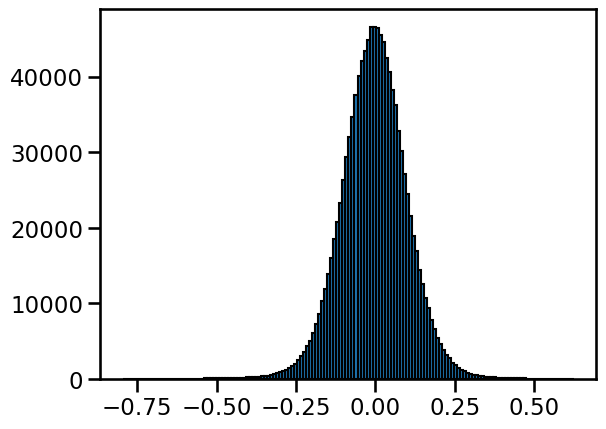

In [107]:
data = z['rna'].view(-1).detach().numpy()/16.972

num_bins = 150  # 设定区间数量
counts, bins, _ = plt.hist(data, bins=num_bins, edgecolor='black')

# # 绘制柱状图
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(counts)), counts, width=1, edgecolor='black')
# plt.xticks(range(len(bins)-1), bins[:-1])
# plt.xlabel('区间')
# plt.ylabel('频次')
# plt.title('自动定义区间的频次柱状图')
# plt.show()

In [259]:
data.min(),data.max()

(-0.79446214, 0.6255352)

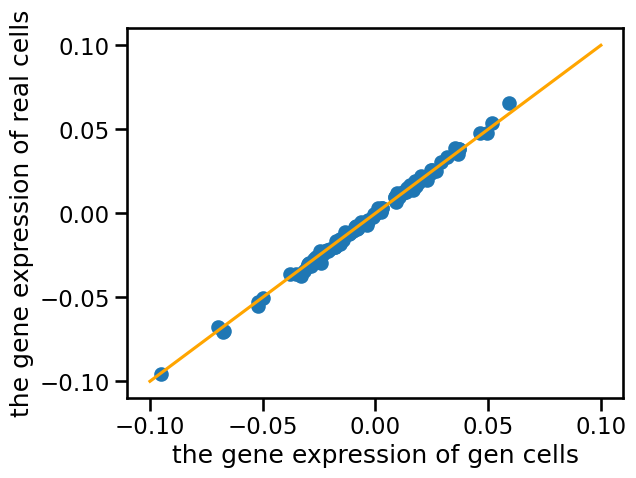

In [352]:
plt.figure()
lim = 0.1
# plt.ylim((-0.75,0.75))
# plt.xlim((-0,lim))
plt.xlabel('the gene expression of gen cells')
plt.ylabel('the gene expression of real cells')
plt.scatter(rna_seq.squeeze(1).mean(axis=0),z['rna'].mean(axis=0).detach().numpy()/16.972)
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))1.6291
plt.plot([-lim,lim],[-lim,lim],color='orange')

In [280]:
print('RNA..................')
RNA = rna_seq.squeeze(1)[:z['rna'].shape[0]]*16.972
print(abs(z['rna']).mean().item())
print(abs(RNA).mean())
print('spearman=',stats.spearmanr(z['rna'].mean(axis=0).detach().numpy(), RNA.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(z['rna'].mean(axis=0).detach().numpy(), RNA.mean(axis=0))[0][1])
print(np.mean((RNA-z['rna'].detach().numpy())**2))
print(np.linalg.norm(RNA.mean(axis=0)-z['rna'].detach().numpy().mean(axis=0)))

adata = np.concatenate((RNA, z['rna'].detach().numpy()),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(RNA.shape[0])]+[f"gen_Cell" for i in range(z['rna'].detach().numpy().shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(RNA.shape[0])]+[f"gen_Cell" for i in range(z['rna'].detach().numpy().shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

print('ATAC..................')
ATAC = atac_seq.squeeze(1)[:z['atac'].shape[0]]*41.238
print(abs(z['atac']).mean().item())
print(abs(ATAC).mean())
print('spearman=',stats.spearmanr(z['atac'].mean(axis=0).detach().numpy(), ATAC.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(z['atac'].mean(axis=0).detach().numpy(), ATAC.mean(axis=0))[0][1])
print(np.mean((ATAC-z['atac'].detach().numpy())**2))
print(np.linalg.norm(ATAC.mean(axis=0)-z['atac'].mean(axis=0).detach().numpy()))

adata = np.concatenate((ATAC, z['atac'].detach().numpy()),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(ATAC.shape[0])]+[f"gen_Cell" for i in range(z['atac'].detach().numpy().shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(ATAC.shape[0])]+[f"gen_Cell" for i in range(z['atac'].detach().numpy().shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

RNA..................


ValueError: cannot select an axis to squeeze out which has size not equal to one

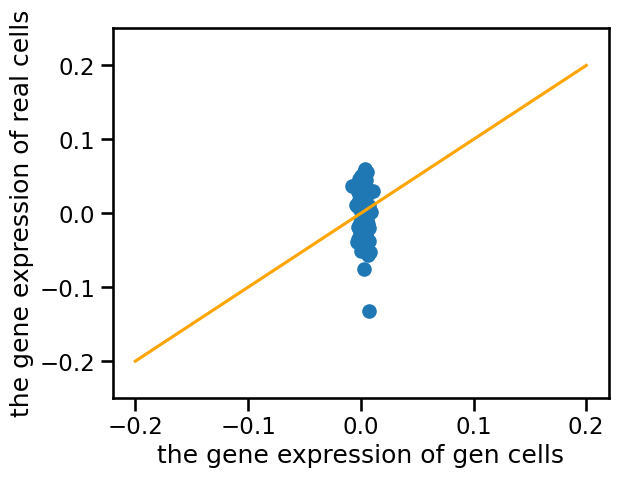

In [328]:
plt.figure()
lim = 0.2
plt.ylim((-0.25,0.25))
# plt.xlim((-0,lim))
plt.xlabel('the gene expression of gen cells')
plt.ylabel('the gene expression of real cells')
plt.scatter(atac_seq.squeeze(-1).mean(axis=0),z['atac'].mean(axis=0).detach().numpy()/41.238)
# plt.scatter(np.expm1(cell_data).mean(axis=0),np.expm1(cell_gen).mean(axis=0))
plt.plot([-lim,lim],[-lim,lim],color='orange')

loss curve

In [94]:
df = pd.read_csv('/stor/lep/workspace/multi_diffusion/MM-Diffusion/outputs/checkpoints/open_lr1e4_w64_scale3_80w/progress.csv',header=None)
loss = df['loss'].values

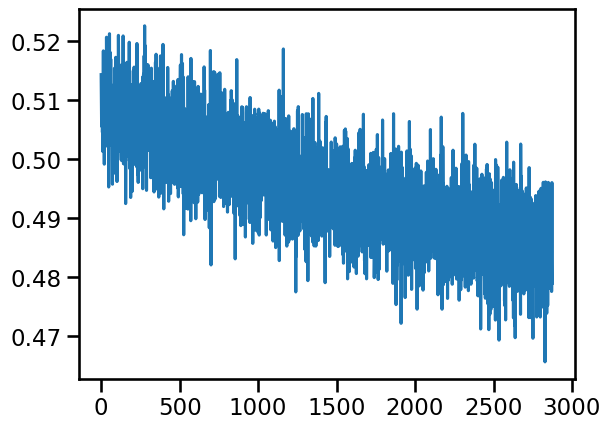

In [96]:
plt.plot(loss)